In [1]:
import os
from utils.config import process_config, init_obj
import models.gw_models as models_module
import data_loader.gw_dataloader as data_loader_module
import tensorflow as tf
from utils.utils import configure_device

configure_device()

Found 1 GPU(s), configuring memory settings...
Enabled memory growth for GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
from utils.eval import load_model_and_data_loader
import data_loader.gw_dataloader as data_loader_module

config, _ = process_config("/home/nino/GW/Keras-Project-Template/configs/gw_mapped_ae_config.json")
data_loader = init_obj(config, "data_loader", data_loader_module)

In [4]:
import models.gw_models as models_module

model = init_obj(config, "model", models_module, data_loader = data_loader)

2024-11-24 16:18:36.704201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 16:18:37.925157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15917 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [2]:
import matplotlib.pyplot as plt
from joblib import load

hist = load("/home/nino/GW/Keras-Project-Template/experiments/2024-11-25_15-38-43/Small_blocks_training_attempt_unregularized/checkpoints/history_model.bin")
hist.keys()

dict_keys(['loss', 'latent_components_loss', 'output_loss', 'val_loss', 'val_latent_components_loss', 'val_output_loss', 'lr'])

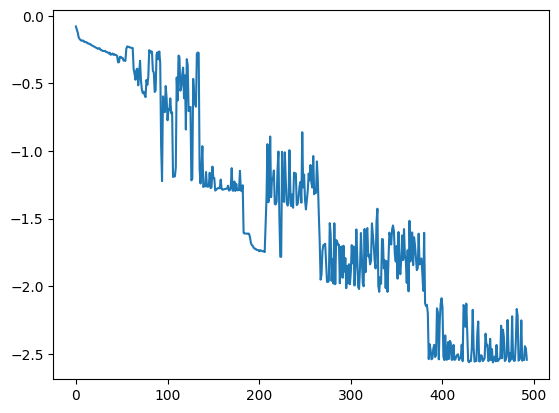

In [5]:
plt.plot(hist['output_loss'])

In [13]:
model.autoencoder.autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 lambda (Lambda)                (None, 2048)         0           ['input_2[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                                  
 dense_86 (Dense)               (None, 512)          1049088     ['lambda[0][0]']                 
                                                                                            

## Residual block-based NN

In [2]:
from keras import layers

def dense_residual_block(x, n_neurons, n_layers, dense_shortcut):

    y = layers.Dense(units = n_neurons, activation = 'leaky_relu')(x)

    for _ in range(n_layers-1):
        y = layers.Dense(units = n_neurons, activation = 'leaky_relu')(y)
        y = layers.LayerNormalization()(y)

    if dense_shortcut:
        z = layers.Dense(units = n_neurons, activation = 'leaky_relu')(x)

        for _ in range(n_layers // 4):
            z = layers.Dense(units = n_neurons, activation = 'leaky_relu')(z)
            z = layers.LayerNormalization()(z)
            
    else:
        z = x

    return layers.Add()([z, y])


def stack_residual_blocks(x, n_blocks, n_neurons, layers_per_block, dense_shortcut = True):

    for _ in range(n_blocks):
        x = dense_residual_block(x, n_neurons, layers_per_block, dense_shortcut)
    
    return x

In [3]:
from keras import Input, Model

inp = Input(3)

opt = stack_residual_blocks(x = inp, n_blocks = 10, n_neurons = 1024, layers_per_block = 5)

model = Model(inp, opt)
model.summary()

2024-11-18 13:56:57.255036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 13:56:58.461796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15680 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         4096        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1024)         1049600     ['dense[0][0]']                  
                                                                                                  
 layer_normalization (LayerNorm  (None, 1024)        2048        ['dense_1[0][0]']                
 alization)                                                                                   

## Training curves review

In [ ]:
from joblib import load

hist_ae = load("/home/nino/GW/Keras-Project-Template/experiments/2024-11-10_17-56-50/deep_residual_regularized_mapped_autoencoder/checkpoints/history_autoencoder.bin")
hist_train = load("/home/nino/GW/Keras-Project-Template/experiments/2024-11-10_17-56-50/deep_residual_regularized_mapped_autoencoder/checkpoints/history_model.bin")
hist_retrain_full = load("/home/nino/GW/Keras-Project-Template/experiments/2024-11-10_17-56-50/deep_residual_regularized_mapped_autoencoder/retraining_overlap/history.bin")
hist_tl_full = load("/home/nino/GW/Keras-Project-Template/experiments/2024-11-10_17-56-50/deep_residual_regularized_mapped_autoencoder/transfer_learning_overlap/history.bin")
# hist_cvae = load("/home/nino/GW/Keras-Project-Template/experiments/2024-11-15_08-10-13/deep_cVAE/checkpoints/history.bin")
hist_retrain = hist_retrain_full.history
hist_tl = hist_tl_full.history

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2024-11-14 19:52:32    841129008
config.json                                    2024-11-14 19:52:30        29784
metadata.json                                  2024-11-14 19:52:30           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......functional
.........layers
............dense
...............vars
..................0
..................1
............dense_1
...............vars
..................0
..................1
............dense_10
...............vars
..................0
..................1
............dense_11
...............vars
..................0
..................1
............dense_12
...............vars
..................0
..................1
............dense_13
...............vars
..................0
..................1
............dense_14
...............vars
..................0

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def plot_hist(hist, loss_name, val_loss_name, n, log, title = ""):

    loss_vec = hist[loss_name][n[0]:n[1]]
    val_loss_vec = hist[val_loss_name][n[0]:n[1]]

    min_range = min(loss_vec + val_loss_vec)
    max_range = max(loss_vec + val_loss_vec)
    lr_vec = hist['lr'][n[0]:n[1]]
    drop_indices = [i for i in range(1, len(lr_vec)) if lr_vec[i] < lr_vec[i - 1]]
    
    matplotlib.rcParams['figure.figsize'] = (10, 6)
    plt.plot(loss_vec, label = loss_name, alpha = 0.75, linewidth = 0.8)
    plt.plot(val_loss_vec, label = val_loss_name, alpha = 0.5, linewidth = 0.8)
    for idx in drop_indices:
        plt.vlines(x = idx, ymin = min_range, ymax = max_range, linewidth = 0.5, linestyle = 'dashed', color = 'black')
    plt.legend()
    plt.title(title)
    if log:
        plt.yscale('log')

In [4]:
hist_cvae.keys()

dict_keys(['loss', 'reconstruction_loss', 'kl_loss', 'val_loss', 'val_reconstruction_loss', 'val_kl_loss', 'lr'])

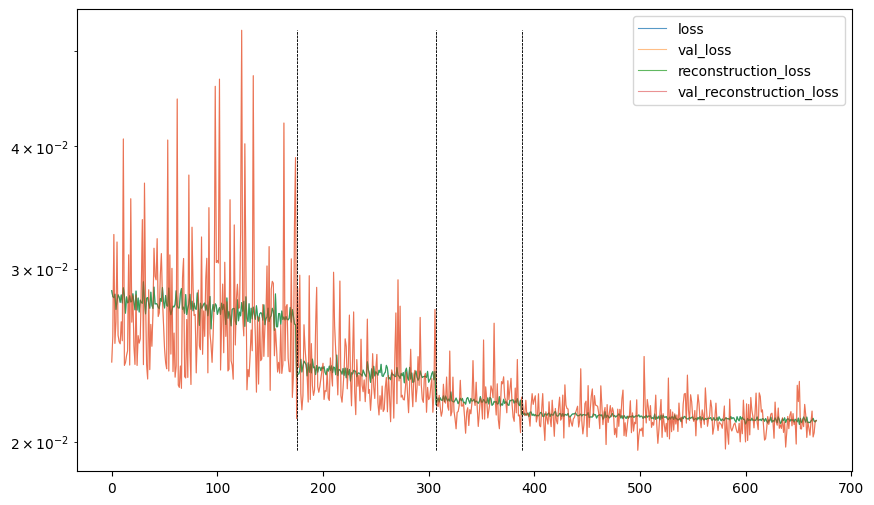

In [9]:
hist = hist_cvae
log_bool = True
interval = [2300, -1]

plot_hist(hist, list(hist.keys())[0], list(hist.keys())[3], interval, log = log_bool)
plot_hist(hist, list(hist.keys())[1], list(hist.keys())[4], interval, log = log_bool)
# plot_hist(hist, list(hist.keys())[2], list(hist.keys())[5], interval, log = log_bool)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize weights
def visualize_weights(model):
    for layer in model.layers:
        if len(layer.get_weights()) > 0:  # Check if the layer has weights
            weights, biases = layer.get_weights()
            
            # Plot weights
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(weights, aspect='auto', cmap='viridis')
            plt.colorbar()
            plt.title(f"Weights of {layer.name}")
            plt.xlabel("Output Neurons")
            plt.ylabel("Input Neurons")
            
            # Plot biases
            plt.subplot(1, 2, 2)
            plt.bar(range(len(biases)), biases, color='blue')
            plt.title(f"Biases of {layer.name}")
            plt.xlabel("Output Neurons")
            plt.ylabel("Bias Value")
            plt.tight_layout()
            plt.show()

# Visualize weights of the model
visualize_weights(hist_retrain_full.model.layers[1])


# Deep architecture

In [2]:
config_dir = "/home/nino/GW/Keras-Project-Template/configs/gw_mapped_ae_config.json"
config, _ = process_config(config_dir)
# config.data_loader.data_output_type = "hphc"
data_loader = init_obj(config, "data_loader", data_loader_module)

In [3]:
import keras
from keras import layers

n_layers = 100
n_units = 2048
lat_dim = 200
res_layers = []

inp = keras.Input(data_loader.in_out_shapes['input_shape'])
x = layers.Dense(n_units, activation = 'leaky_relu', kernel_initializer = 'glorot_uniform')(inp)

for ct in range(int(n_layers/4)):
    
    x = layers.Dense(n_units, activation = 'leaky_relu', kernel_initializer = 'glorot_uniform')(x)
    if ct % 10 == 0:
        res_layers.append(tf.identity(x))

for ct in range(int(n_layers/4)):

    if ct % 10 == 0:
        x = layers.Dense(n_units, activation = 'leaky_relu', kernel_initializer = 'glorot_uniform')(x + res_layers.pop(-1))

    else:
        x = layers.Dense(n_units, activation = 'leaky_relu', kernel_initializer = 'glorot_uniform')(x)

res_layers = []

x = layers.Dense(lat_dim, activation = 'leaky_relu', kernel_initializer = 'glorot_uniform')(x)

for ct in range(int(n_layers/4)):
    
    x = layers.Dense(n_units, activation = 'leaky_relu', kernel_initializer = 'glorot_uniform')(x)
    if ct % 10 == 0:
        res_layers.append(tf.identity(x))

for ct in range(int(n_layers/4)):

    if ct % 10 == 0:
        x = layers.Dense(n_units, activation = 'leaky_relu', kernel_initializer = 'glorot_uniform')(x + res_layers.pop(-1))

opt = layers.Dense(4096)(x)

model = keras.Model(inp, opt)
model.summary()

2024-10-30 12:14:25.209814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 12:14:26.047842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20337 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 2048)         8192        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2048)         4196352     ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 2048)         4196352     ['dense_1[0][0]']                
                                                                                              

In [4]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-4), loss = 'mae')

model.fit(x = data_loader.get_generator_train_data(),
          validation_data = data_loader.get_generator_test_data(),
          epochs = 15          
          )

Epoch 1/15
157/157 [==============================] - 20s 98ms/step - loss: 14.3377 - val_loss: 2.2028
Epoch 2/15
104/157 [==================>...........] - ETA: 4s - loss: 4.4690

KeyboardInterrupt: 

# Figures for regularization experiments

In [2]:
from joblib import load
import numpy as np

path = "/home/nino/GW/Keras-Project-Template/experiments"
fig_dir = "/home/nino/GW/Keras-Project-Template/experiments/regularization_experiment_figures"

first_train_means = {}
retrain_means = {}
tl_means = {}
ae_means = {}

for model in os.listdir(path):

    if "2024" not in model:
        continue

    model_path = os.path.join(path, model)
    model_name = os.listdir(model_path)[0]
    model_path = os.path.join(model_path, model_name)

    if model_name in first_train_means.keys():
        model_name = model_name + "_r"

    config, _ = process_config(os.path.join(model_path, "checkpoints/config.json"))

    # Figures from first training performance
    try:
        test_mismatches_path = os.path.join(model_path, "figures/mismatches_test.bin")
        first_train_means[model_name] = np.mean(load(test_mismatches_path))
    except:
        print(f"Training for model {model_name} not found")

    # Figures from retraining performance
    try:    
        test_mismatches_path = os.path.join(model_path, "retraining_overlap/retrain_figures/mismatches_test.bin")
        retrain_means[model_name] = np.mean(load(test_mismatches_path))
    except:
        print(f"Retraining for model {model_name} not found")

    # Figures from transfer learning performance
    try:
        test_mismatches_path = os.path.join(model_path, "transfer_learning_overlap/tl_figures/mismatches_test.bin")
        tl_means[model_name] = np.mean(load(test_mismatches_path))
    except:
        print(f"Transfer learning for model {model_name} not found")

    # Figures from autoencoder performance

    try:
        test_mismatches_path = os.path.join(model_path, "ae_figures/mismatches_test.bin")
        ae_means[model_name] = np.mean(load(test_mismatches_path))
    except:
        print(f"Autoencoder evaluation for model {model_name} not found")



For extracting comparisons with unregularized

In [12]:
from joblib import load
import numpy as np

path = "/home/nino/GW/Keras-Project-Template/experiments/ae_experiments"
fig_dir = "/home/nino/GW/Keras-Project-Template/experiments/unregularized_experiment_figures"

first_train_data = {}
retrain_data = {}
tl_data = {}
ae_data = {}

for model in os.listdir(path):

    if "2024" not in model:
        continue

    model_path = os.path.join(path, model)
    model_name = os.listdir(model_path)[0]

    if "ldim15_mapid3_aeid1" not in model_name:

        print(model_name)

        continue

    model_path = os.path.join(model_path, model_name)

    if model_name in first_train_data.keys():
        model_name = model_name + "_r"

    config, _ = process_config(os.path.join(model_path, "checkpoints/config.json"))

    # Figures from first training performance
    try:
        test_mismatches_path = os.path.join(model_path, "figures/mismatches_test.bin")
        first_train_data[model_name] = np.mean(load(test_mismatches_path))
    except:
        print(f"Training for model {model_name} not found")

    # Figures from retraining performance
    try:    
        test_mismatches_path = os.path.join(model_path, "retraining_overlap/retrain_figures/mismatches_test.bin")
        retrain_data[model_name] = np.mean(load(test_mismatches_path))
    except:
        print(f"Retraining for model {model_name} not found")

    # Figures from transfer learning performance
    try:
        test_mismatches_path = os.path.join(model_path, "transfer_learning_overlap/tl_figures/mismatches_test.bin")
        tl_data[model_name] = np.mean(load(test_mismatches_path))
    except:
        print(f"Transfer learning for model {model_name} not found")

    # Figures from autoencoder performance

    try:
        test_mismatches_path = os.path.join(model_path, "ae_figures/mismatches_test.bin")
        ae_data[model_name] = np.mean(load(test_mismatches_path))
    except:
        print(f"Autoencoder evaluation for model {model_name} not found")



qz_ae_ldim5_mapid1_aeid0_uninit
qz_ae_ldim5_mapid1_aeid1_uninit
Retraining for model qz_ae_ldim15_mapid3_aeid1_uninit not found
Autoencoder evaluation for model qz_ae_ldim15_mapid3_aeid1_uninit not found
qz_ae_ldim15_mapid3_aeid0_uninit
qz_ae_ldim15_mapid1_aeid0_uninit
qz_ae_ldim5_mapid0_aeid1
qz_ae_ldim5_mapid3_aeid0_uninit
qz_ae_ldim5_mapid1_aeid1
qz_ae_ldim5_mapid2_aeid0
qz_ae_ldim5_mapid2_aeid1_uninit
qz_ae_ldim15_mapid3_aeid0
qz_ae_ldim15_mapid2_aeid0
qz_ae_ldim5_mapid2_aeid0
qz_ae_ldim15_mapid1_aeid0
qz_ae_ldim15_mapid2_aeid1
qz_ae_ldim5_mapid2_aeid0_uninit
qz_ae_ldim15_mapid1_aeid0
qz_ae_ldim5_mapid0_aeid0
qz_ae_ldim15_mapid2_aeid1_uninit
qz_ae_ldim5_mapid0_aeid1_uninit
qz_ae_ldim5_mapid3_aeid0_uninit
qz_ae_ldim15_mapid0_aeid0
qz_ae_ldim15_mapid0_aeid1_uninit
Retraining for model qz_ae_ldim15_mapid3_aeid1_uninit_r not found
Autoencoder evaluation for model qz_ae_ldim15_mapid3_aeid1_uninit_r not found
qz_ae_ldim15_mapid3_aeid0_uninit
qz_ae_ldim5_mapid0_aeid1_uninit
qz_ae_ldim15_m

In [30]:
ae_vals = list(ae_data.values())
ae_lines = [np.min(ae_vals), np.mean(ae_vals), np.max(ae_vals)]

first_train_vals = list(first_train_data.values())
first_train_lines = [np.min(first_train_vals), np.mean(first_train_vals), np.max(first_train_vals)]

tl_vals = list(tl_data.values())
tl_lines = [np.min(tl_vals), np.mean(tl_vals), np.max(tl_vals)]

retrain_vals = list(retrain_data.values())
retrain_lines = [np.min(retrain_vals), np.mean(retrain_vals), np.max(retrain_vals)]

In [38]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import re

def make_scatter_plot(dictionary, main, saving_path, y_scale=False, lines=None):
    # Prepare lists for plotting
    x_values = []  # Regularization coefficients for x-axis
    y_values = list(dictionary.values())  # Performance values from the dictionary
    shapes = []

    # Define shapes for 'l1' and 'custom'
    shape_map = {
        'l1': 'o',         # Circle for 'l1'
        'custom': '^'      # Triangle for 'custom'
    }
    color_map = {
        'o': "blue",
        '^': "red"
    }

    for key in dictionary.keys():
        # Determine shape based on 'l1' or 'custom' in the key
        if "l1" in key:
            shapes.append(shape_map['l1'])
        elif "custom" in key:
            shapes.append(shape_map['custom'])
        
        # Modified regex to find all float values, excluding 'l1_' prefix
        matches = re.findall(r'(?<!l1_)(\d+\.?\d*e?-?\d*)', key)  # Negative lookbehind for 'l1_'
        
        # Use the second match if there are two; otherwise, use the first match (if it exists)
        if matches:
            float_value = float(matches[1]) if len(matches) > 1 else float(matches[0])
            x_values.append(float_value)

    # Plot the scatter plot with extracted x_values and shapes
    plt.figure(figsize=(8, 6))
    for x, y, shape in zip(x_values, y_values, shapes):
        plt.scatter(x, y, c=color_map[shape], marker=shape, s=40)

    # Create the legend for shapes
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='L1', markerfacecolor='blue', markersize=10),
        Line2D([0], [0], marker='^', color='w', label='Feature-wise', markerfacecolor='red', markersize=10)
    ]
    plt.legend(handles=legend_elements, title="Regularization Type", loc="best")

    # Plot horizontal lines if 'lines' argument is provided
    if lines and len(lines) == 3:
        plt.axhline(y=lines[0], color='black', linestyle='-', linewidth=1, label="Minimum Mean Mismatch")
        plt.axhline(y=lines[1], color='gray', linestyle='--', linewidth=1, label="Average Mean Mismatch")
        plt.axhline(y=lines[2], color='black', linestyle='-', linewidth=1, label="Maximum Mean Mismatch")

        # Additional legend for horizontal lines
        line_legend_elements = [
            Line2D([0], [0], color='gray', lw=1, linestyle='--', label="Average Mean Mismatch")
        ]
        plt.legend(handles=legend_elements + line_legend_elements, loc="upper left")

    # Add plot details
    if y_scale:
        plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.xlabel("Regularization Coefficient")
    plt.ylabel("Mean mismatch")
    plt.title(main)
    plt.savefig(saving_path)


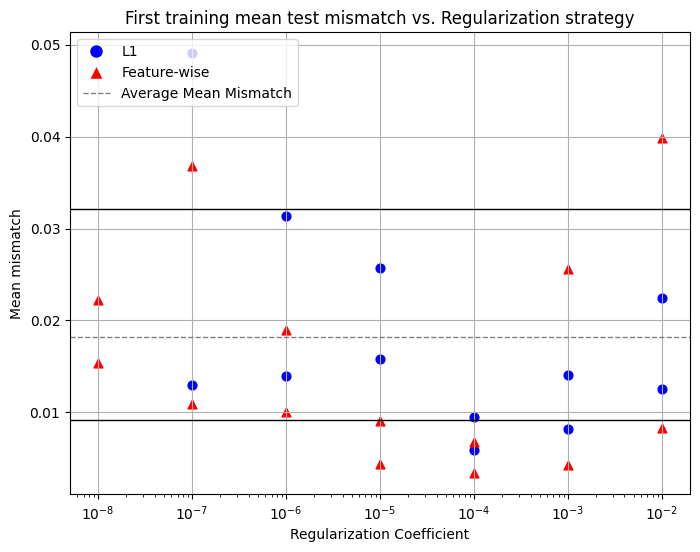

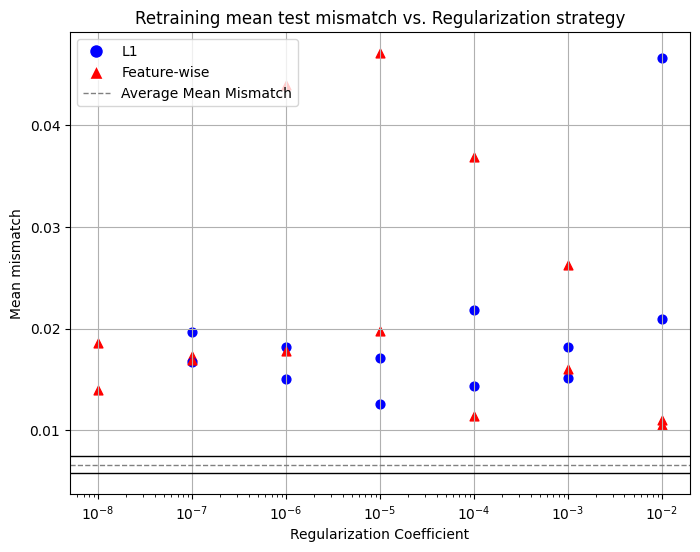

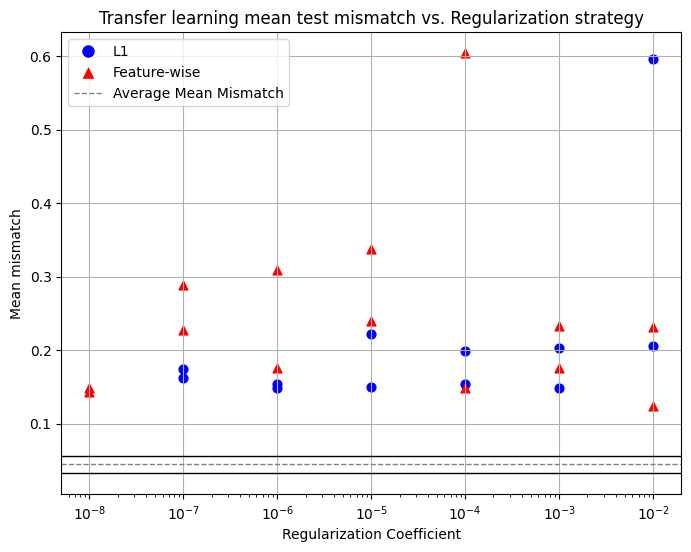

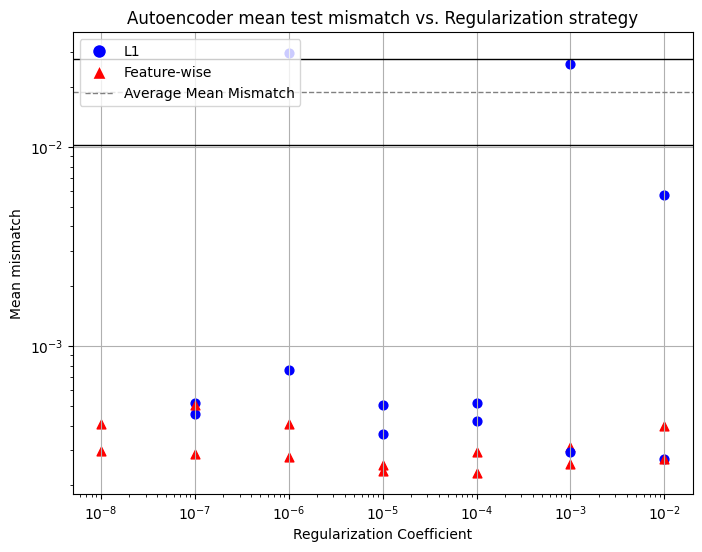

In [39]:
make_scatter_plot(first_train_means, "First training mean test mismatch vs. Regularization strategy", "/home/nino/GW/Keras-Project-Template/experiments/regularization_experiment_figures/first_training.png", lines = first_train_lines)
make_scatter_plot(retrain_means, "Retraining mean test mismatch vs. Regularization strategy", "/home/nino/GW/Keras-Project-Template/experiments/regularization_experiment_figures/retraining.png", lines = retrain_lines)
make_scatter_plot(tl_means, "Transfer learning mean test mismatch vs. Regularization strategy", "/home/nino/GW/Keras-Project-Template/experiments/regularization_experiment_figures/transfer_learning.png", lines = tl_lines)
make_scatter_plot(ae_means, "Autoencoder mean test mismatch vs. Regularization strategy", "/home/nino/GW/Keras-Project-Template/experiments/regularization_experiment_figures/autoencoder.png", y_scale = True, lines = ae_lines)

# cVAE + Normalizing flows

In [50]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

In [101]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

# Aliases for simplicity
tfd = tfp.distributions
tfb = tfp.bijectors

# Function to create the RationalQuadraticSpline bijector
def create_rational_quadratic_spline():
    num_bins = 8  # Number of bins for the spline
    range_min = -5.0  # Lower bound of the spline
    range_max = 5.0   # Upper bound of the spline

    # Create the spline bijector
    spline_bijector = tfb.RationalQuadraticSpline(
        bin_widths=[0.125] * num_bins,  # 8 bins means 7 intervals
        bin_heights=[0.125] * num_bins,  # 8 bin heights
        knot_slopes=[1.0] * (num_bins - 1),  # Slopes at each knot (7 knots for 8 bins)
        range_min=range_min
    )
    return spline_bijector

# Function to test the RationalQuadraticSpline
def test_rational_quadratic_spline():
    # Create spline bijector
    spline_bijector = create_rational_quadratic_spline()

    # Create some sample data to transform
    x = np.linspace(-5, 5, num=15, dtype=np.float32)  # 10 points in the range [-5, 5]
    x_tf = tf.convert_to_tensor(x, dtype=tf.float32)

    # Apply the bijector (forward transformation)
    y_tf = spline_bijector.forward(x_tf)

    # Apply the inverse transformation (back to original space)
    x_inverse_tf = spline_bijector.inverse(y_tf)

    # Print the original, transformed, and inverse-transformed data
    print("Original x:", x)
    print("Transformed y:", y_tf.numpy())
    print("Inverse x (should match original x):", x_inverse_tf.numpy())

# Run the test
test_rational_quadratic_spline()


Original x: [-5.         -4.285714   -3.5714285  -2.857143   -2.142857   -1.4285715
 -0.71428573  0.          0.71428573  1.4285715   2.142857    2.857143
  3.5714285   4.285714    5.        ]
Transformed y: [-5.         -4.285714   -3.5714285  -2.857143   -2.142857   -1.4285715
 -0.71428573  0.          0.71428573  1.4285715   2.142857    2.857143
  3.5714285   4.285714    5.        ]
Inverse x (should match original x): [-5.         -4.285714   -3.5714285  -2.857143   -2.142857   -1.4285715
 -0.71428573  0.          0.71428573  1.4285715   2.142857    2.857143
  3.5714285   4.285714    5.        ]


In [104]:
bijection = create_rational_quadratic_spline()
bijection.forward(tf.convert_to_tensor(np.random.uniform((64, 32)), dtype = tf.float32))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([55.0295  , 25.280756], dtype=float32)>

In [61]:
x = np.linspace(0.1, 5, num=8, dtype=np.float32)
x_tf = tf.convert_to_tensor(x, dtype=tf.float32)

x_tf.shape

TensorShape([8])

In [168]:
def leaky_relu_with_epsilon(x, alpha=1.0, epsilon=1e-5):
    return tf.where(x < epsilon, epsilon, alpha * x)

class LeakyReLUWithEpsilonLayer(layers.Layer):
    def __init__(self, alpha=1.0, epsilon=1e-5, **kwargs):
        super(LeakyReLUWithEpsilonLayer, self).__init__(**kwargs)
        self.alpha = alpha
        self.epsilon = epsilon

    def call(self, inputs):
        return leaky_relu_with_epsilon(inputs, alpha=self.alpha, epsilon=self.epsilon)

class RationalQuadraticSplineFlow(tf.keras.layers.Layer):
    def __init__(self, latent_dim, num_bins=8):
        super(RationalQuadraticSplineFlow, self).__init__()
        self.latent_dim = latent_dim
        self.num_bins = num_bins
        
        # Neural network for predicting spline parameters
        self.spline_net = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(self.latent_dim * self.num_bins * 3)  # For widths, heights, slopes
        ])

    def call(self, z):
        params = self.spline_net(z)
        params = tf.reshape(params, (-1, self.latent_dim, self.num_bins * 3))
        
        # Normalize widths and heights
        widths = tf.nn.softmax(params[:, :, :self.num_bins], axis=-2)
        heights = tf.nn.softmax(params[:, :, self.num_bins:2*self.num_bins], axis=-2)

        slopes = tf.math.softplus(params[:, :, 2*self.num_bins:-1])

        # Create the bijector
        bijector = tfb.RationalQuadraticSpline(bin_widths=widths, bin_heights=heights, knot_slopes=slopes)
        
        # Apply the bijector forward transformation
        z_transformed = bijector.forward(z)
        
        # Calculate the log_det_jacobian for flow's contribution to the loss
        log_det_jacobian = bijector.inverse_log_det_jacobian(z_transformed, event_ndims=1)
        
        return z_transformed, log_det_jacobian

def create_encoder(input_dim, latent_dim):
    inputs = Input(shape=(input_dim,))
    x = layers.Dense(512, activation='leaky_relu')(inputs)
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.Dense(512, activation='leaky_relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    return Model(inputs, [z_mean, z_log_var], name='encoder')

def create_decoder(latent_dim, output_dim):
    inputs = Input(shape=(latent_dim,))
    x = layers.Dense(512, activation='leaky_relu')(inputs)
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.Dense(512, activation='leaky_relu')(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    return Model(inputs, outputs, name='decoder')

def create_vae(input_dim, latent_dim, num_bins=8):
    # Input
    inputs = Input(shape=(input_dim,))

    # Encoder
    encoder = create_encoder(input_dim, latent_dim)
    z_mean, z_log_var = encoder(inputs)

    # Reparameterization trick
    eps = tf.random.normal(shape=tf.shape(z_mean))
    z = z_mean + tf.exp(0.5 * z_log_var) * eps

    # Apply Neural Spline Flow via custom layer
    flow_layer = RationalQuadraticSplineFlow(latent_dim, num_bins)
    z_transformed, log_det_jacobian = flow_layer(z)

    # Decoder
    decoder = create_decoder(latent_dim, input_dim)
    reconstruction = decoder(z_transformed)

    return Model(inputs, [reconstruction, z_mean, z_log_var, log_det_jacobian], name='vae')

def vae_loss(inputs, reconstruction, z_mean, z_log_var, log_det_jacobian):
    # Reconstruction loss (Binary Crossentropy)
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inputs, reconstruction))

    # KL Divergence with Flow
    kl_divergence = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_divergence = tf.reduce_mean(tf.reduce_sum(kl_divergence, axis=1))

        
    if tf.reduce_any(tf.math.is_nan(log_det_jacobian)):
        raise ValueError("NaN arisen in the logarithm of the Jacobian")

    if tf.reduce_any(tf.math.is_nan(kl_divergence)):
        raise ValueError("NaN arisen in Kullback-Leibler divergence")

    return tf.reduce_mean(reconstruction_loss + kl_divergence + log_det_jacobian)


In [169]:
# Hyperparameters
latent_dim = 32
input_dim = 784  # Assuming MNIST data
num_bins = 8
epochs = 20
batch_size = 1024

# Prepare data (using MNIST as an example)
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

# Build and compile the model
vae = create_vae(input_dim=input_dim, latent_dim=latent_dim, num_bins=num_bins)
optimizer = tf.keras.optimizers.Adam()

from tensorflow.keras.utils import Progbar

# Assuming `epochs`, `x_train`, `batch_size`, `vae`, `vae_loss`, and `optimizer` are already defined

for epoch in range(epochs):
    # Initialize progress bar
    progbar = Progbar(target=len(x_train) // batch_size)
    
    for batch in range(0, len(x_train), batch_size):
        x_batch = x_train[batch:batch + batch_size]
        
        with tf.GradientTape() as tape:
            reconstruction, z_mean, z_log_var, log_det_jacobian = vae(x_batch)
            loss = vae_loss(x_batch, reconstruction, z_mean, z_log_var, log_det_jacobian)

        gradients = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(gradients, vae.trainable_weights))
        
        # Update the progress bar
        progbar.add(1, values=[('loss', loss.numpy())])
    
    print(f'Epoch {epoch + 1} completed')


59/58 [==============================] - 33s 431ms/step - loss: 0.3883
Epoch 1 completed
59/58 [==============================] - 24s 404ms/step - loss: 0.2534
Epoch 2 completed
59/58 [==============================] - 26s 443ms/step - loss: 0.2029
Epoch 3 completed
59/58 [==============================] - 24s 405ms/step - loss: 0.2116
Epoch 4 completed
59/58 [==============================] - 24s 414ms/step - loss: 0.1124
Epoch 5 completed
 8/58 [===>..........................] - ETA: 18s - loss: 0.1108

ValueError: NaN arisen in the logarithm of the Jacobian

# Regularization

In [3]:
from keras import layers, Input, Model
from utils.loss import ComponentWiseRegularizer

def reset_weights(model):
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'bias_initializer'):
            layer.kernel.assign(layer.kernel_initializer(tf.shape(layer.kernel)))
            if layer.bias is not None:
                layer.bias.assign(layer.bias_initializer(tf.shape(layer.bias)))

inp = Input(4096)

x = layers.Dense(512, activation = 'relu', kernel_initializer = "glorot_uniform")(inp)
x = layers.Dense(512, activation = 'relu', kernel_initializer = "glorot_uniform")(x)
x = layers.Dense(512, activation = 'relu', kernel_initializer = "glorot_uniform")(x)

enc = layers.Dense(20, kernel_regularizer = ComponentWiseRegularizer(coef = 1e-5, exp = 0.6))(x)
# enc = layers.Dense(20)(x)

y = layers.Dense(512, activation = 'relu', kernel_initializer = "glorot_uniform")(enc)
y = layers.Dense(512, activation = 'relu', kernel_initializer = "glorot_uniform")(y)
dec = layers.Dense(4096, kernel_initializer = "glorot_uniform")(y)

encoder = Model(inp, enc)
decoder = Model(enc, dec)
autoencoder = Model(inp, dec)

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense_3 (Dense)             (None, 512)               2097664   
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 20)                10260     
                                                                 
 dense_7 (Dense)             (None, 512)               10752     
                                                                 
 dense_8 (Dense)             (None, 512)               2626

In [4]:
reset_weights(autoencoder)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense_3 (Dense)             (None, 512)               2097664   
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 20)                10260     
                                                                 
 dense_7 (Dense)             (None, 512)               10752     
                                                                 
 dense_8 (Dense)             (None, 512)               2626

/home/nino/miniconda3/envs/Tensorflow/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [1]:
import tensorflow as tf

tf.__version__

2024-10-17 10:15:36.581956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 10:15:36.782065: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-17 10:15:37.753403: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nino/miniconda3/envs/Tensorflow/lib/
2024-10-17 10:15:37.753502: W tensorflow/co

'2.11.0'

# Custom regularization layer

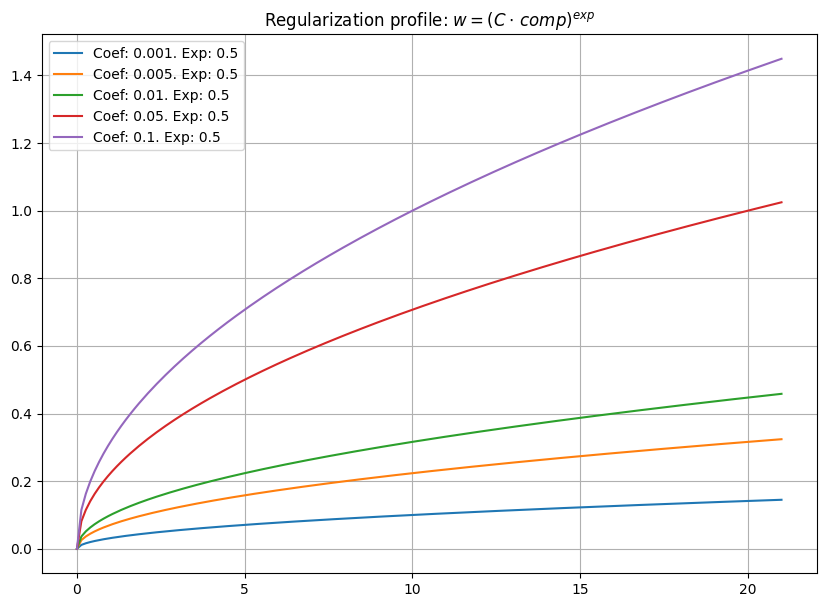

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def get_array(pars):

    coef, exp = pars
    x = np.linspace(0, 21, 160)

    return x, (x*coef)**exp

plt.rcParams['figure.figsize'] = [10, 7]
xp = 0.5

for cf in [0.001, 0.005, 0.01, 0.05, 0.1,]:
        
        x, y = get_array([cf, xp])
        plt.plot(x, y, label = f"Coef: {cf}. Exp: {xp}")

plt.title("Regularization profile: $w = (C\cdot\,comp)^{exp}$")
plt.legend()
plt.grid()
plt.show()

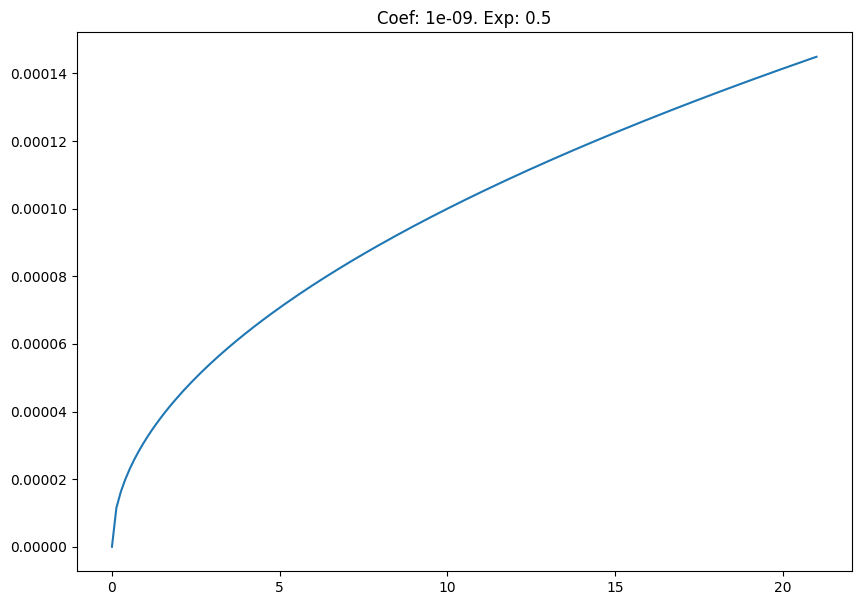

In [3]:
cf, xp = 1e-9, 0.5

x, y = get_array([cf, xp])
plt.plot(x, y)
_=plt.title(f"Coef: {cf}. Exp: {xp}")

In [72]:
tf.transpose(reg_vec)

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0.        , 0.1       , 0.14142135, 0.17320508, 0.2       ,
        0.2236068 , 0.24494895, 0.26457512, 0.2828427 , 0.3       ,
        0.31622776, 0.33166248, 0.34641016, 0.36055514, 0.37416574,
        0.38729835, 0.4       , 0.41231057, 0.42426407, 0.4358899 ]],
      dtype=float32)>

In [74]:
kernel

<tf.Tensor: shape=(512, 20), dtype=float32, numpy=
array([[0.13482156, 0.8406095 , 0.66355246, ..., 0.3416654 , 0.648497  ,
        0.677722  ],
       [0.2107782 , 0.37886512, 0.19025134, ..., 0.83014333, 0.6519663 ,
        0.3311682 ],
       [0.68068695, 0.75519294, 0.9861635 , ..., 0.9535225 , 0.2926643 ,
        0.49049062],
       ...,
       [0.7841279 , 0.7445419 , 0.43340725, ..., 0.5830491 , 0.26384926,
        0.9620815 ],
       [0.28712237, 0.41190726, 0.25418165, ..., 0.29805395, 0.15339917,
        0.09577147],
       [0.81333506, 0.73856074, 0.62442374, ..., 0.06629291, 0.34033397,
        0.5290003 ]], dtype=float32)>

In [73]:
kernel = tf.constant(np.random.uniform(size = [512, 20]), dtype = tf.float32)

kernel * tf.transpose(reg_vec)

<tf.Tensor: shape=(512, 20), dtype=float32, numpy=
array([[0.        , 0.08406095, 0.09384049, ..., 0.14087225, 0.27513397,
        0.29541215],
       [0.        , 0.03788651, 0.0269056 , ..., 0.34227687, 0.27660587,
        0.14435287],
       [0.        , 0.07551929, 0.13946457, ..., 0.3931474 , 0.12416694,
        0.21379991],
       ...,
       [0.        , 0.07445419, 0.06129304, ..., 0.24039732, 0.11194176,
        0.4193616 ],
       [0.        , 0.04119072, 0.03594671, ..., 0.12289079, 0.06508175,
        0.04174582],
       [0.        , 0.07385608, 0.08830684, ..., 0.02733327, 0.14439148,
        0.23058587]], dtype=float32)>

In [99]:
reg_kwargs = {'coef': 1e-3, 'exp': 0.7}

reg = Custom_regularization(**reg_kwargs)

reg_vec = reg.get_regularization_vector(20)

tf.square(tf.constant(np.random.uniform(size = [512, 20]), dtype = tf.float32))
# regularization = tf.tensordot(tf.square(tf.constant(np.random.uniform(size = [512, 20]), dtype = tf.float32)), reg_vec, axes=1)
# regularization

<tf.Tensor: shape=(512, 20), dtype=float32, numpy=
array([[4.9374050e-01, 4.9040355e-02, 1.8098876e-01, ..., 2.5751239e-01,
        3.7411606e-04, 5.0665897e-01],
       [3.5538857e-03, 9.7248232e-01, 5.5462581e-01, ..., 1.2892635e-02,
        3.0799252e-01, 4.8948275e-03],
       [9.0431929e-02, 8.9102900e-01, 1.7486954e-01, ..., 1.4938508e-01,
        5.6486696e-01, 1.0522024e-01],
       ...,
       [7.9345129e-02, 5.5262852e-03, 2.6676959e-01, ..., 5.5432212e-01,
        1.9108237e-01, 2.1143819e-01],
       [2.2251737e-01, 9.0679175e-01, 5.9376663e-01, ..., 6.8698359e-01,
        5.7896337e-04, 7.1404025e-02],
       [7.2947782e-01, 1.3406591e-01, 1.4400050e-01, ..., 9.1858767e-02,
        5.2565658e-01, 9.2187099e-02]], dtype=float32)>

In [100]:
reg_vec

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0.        , 0.00794328, 0.0129039 , 0.01713898, 0.02096245,
        0.02450638, 0.02784235, 0.03101477, 0.0340536 , 0.03698024,
        0.03981073, 0.04255738, 0.04523003, 0.0478366 , 0.05038365,
        0.05287665, 0.05532023, 0.05771839, 0.06007458, 0.06239181]],
      dtype=float32)>

In [78]:
from keras.regularizers import Regularizer

class Custom_regularization(Regularizer):
    def __init__(self, coef=0.01, exp=0.5):
        self.coef = coef
        self.exp = exp

    def __call__(self, x):
        # Ensure that the regularizer returns a scalar by reducing the result
        reg_vector = self.get_regularization_vector(x.shape[-1])
        regularization = tf.abs(x) * reg_vector  # Squaring x for L2-like regularization
        return tf.reduce_sum(regularization)

    def get_regularization_vector(self, vector_length):
        # Create a vector for the regularization term
        x = tf.range(0, vector_length, dtype = tf.float32)
        return tf.expand_dims((x * self.coef) ** self.exp, axis = 0) # axis changed from -1 to 0

    def get_config(self):
        # Return the configuration as required for a Keras custom object
        return {'coef': float(self.coef), 'exp': float(self.exp)}


In [5]:
def test_regularizer_output():
    # Create a single tensor and a batch of tensors
    single_tensor = tf.random.normal((1, 5))  # Single tensor with 5 features
    batch_tensor = tf.random.normal((3, 5))   # Batch of 3 samples, each with 5 features

    # Initialize the custom L2 regularizer
    regularizer = Custom_regularization()

    # Test with single tensor
    print("Single tensor:", single_tensor.numpy())
    print("Regularizer output for single tensor:", regularizer(single_tensor).numpy())

    # Test with batch of tensors
    print("\nBatch tensor:", batch_tensor.numpy())
    print("Regularizer output for batch of tensors:", regularizer(batch_tensor).numpy())

# Run the test
test_regularizer_output()

2024-10-12 08:52:35.732780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 08:52:37.099325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15699 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Single tensor: [[-0.45089522 -1.1740319  -0.404708    0.5524223   0.2926394 ]]


Regularizer output for single tensor: 0.23098288

Batch tensor: [[ 1.010044    0.21192373  1.8411394  -0.28057712  1.070067  ]
 [-0.28121614 -1.4373157   0.08852384  1.363584   -0.01750786]
 [ 0.5341723  -0.6375219  -0.32974544 -0.12125851  0.52869016]]
Regularizer output for batch of tensors: 1.3708025


In [103]:
config_dir = "/home/nino/GW/Keras-Project-Template/configs/gw_mapped_ae_config.json"

config, _ = process_config(config_dir)
# config.data_loader.data_output_type = "hphc"

data_loader = init_obj(config, "data_loader", data_loader_module)

In [125]:
from keras import Model, layers, Input

# reg_kwargs = {'coef': 1e-5, 'exp': 0.6}
reg_kwargs = {'coef': 1e-6, 'exp': 0.7}

inp = Input(4096)

x = layers.Dense(512, activation = 'relu', kernel_initializer = "glorot_uniform")(inp)
x = layers.Dense(512, activation = 'relu', kernel_initializer = "glorot_uniform")(x)
x = layers.Dense(512, activation = 'relu', kernel_initializer = "glorot_uniform")(x)

enc = layers.Dense(20, kernel_regularizer = Custom_regularization(**reg_kwargs))(x)
# enc = layers.Dense(20)(x)

y = layers.Dense(512, activation = 'relu', kernel_initializer = "glorot_uniform")(enc)
y = layers.Dense(512, activation = 'relu', kernel_initializer = "glorot_uniform")(y)
dec = layers.Dense(4096, kernel_initializer = "glorot_uniform")(y)

encoder = Model(inp, enc)
decoder = Model(enc, dec)
autoencoder = Model(inp, dec)

In [126]:
import keras
from utils.loss import ovlp_mae_loss_amp_phs, overlap_amp_phs, mean_absolute_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from keras.regularizers import L2

class RegularizationLossCallback(Callback):
    def add_models_data_loader(self, encoder, autoencoder, data_loader):
        self.encoder = encoder
        self.autoencoder = autoencoder
        self.data_loader = data_loader

    # def on_epoch_end(self, epoch, logs=None):
    #     # Only print every 10 epochs
    #     if (epoch + 1) % 10 == 0 or epoch in [0, 1, 2, 3]:
    #         # Get the regularization losses from the model
    #         pred = self.encoder.predict(self.data_loader.y_train, verbose=0)
    #         regularization_loss = Custom_regularization(**reg_kwargs)(pred)
    #         l2_regularization = L2()(pred)
    #         mean_norm = np.sum(np.linalg.norm(x = pred, ord = 2, axis = 1))

    #         # Print the regularization contribution
    #         print(f"\nEpoch {epoch + 1}:\n    - Regularization loss contribution: {regularization_loss.numpy():.4f}\n")
    #         print(f"    - Standard L2 regularization value: {l2_regularization.numpy():.4f}\n")
    #         print(f"    - Prediction mean norm:             {mean_norm:.4f}\n")

    def on_epoch_end(self, epoch, logs=None):
        # Only print every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch in [0, 1, 2, 3]:
            # Get the regularization losses from the model
            weights = self.encoder.layers[-1].weights
            regularization_loss = Custom_regularization(**reg_kwargs)(weights[0])
            l2_regularization = L2()(weights[0])
            # mean_norm = np.sum(np.linalg.norm(x = weights[0].numpy(), ord = 2, axis = 1))

            # Print the regularization contribution
            print(f"\nEpoch {epoch + 1}:\n    - Regularization loss contribution: {regularization_loss.numpy():.4f}\n")
            print(f"    - Standard L2 regularization value: {l2_regularization.numpy():.4f}\n")
            print(f"    - Weights norm:                     {l2_regularization.numpy()/0.01:.4f}\n")


test_reg = RegularizationLossCallback()
test_reg.add_models_data_loader(encoder, autoencoder, data_loader)

callbacks = []
callbacks.append(EarlyStopping(monitor = 'val_loss', patience = 60))
callbacks.append(ReduceLROnPlateau(monitor = 'loss', factor = 0.5, cooldown = 2, patience = 10, verbose = 1, min_lr = 1e-10))  
callbacks.append(test_reg)

autoencoder.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-4), loss = ovlp_mae_loss_amp_phs, metrics = [overlap_amp_phs, mean_absolute_error])

autoencoder.fit(
    data_loader.get_autoencoder_train_data(),
    batch_size = 128,
    validation_data = data_loader.get_autoencoder_test_data(),
    epochs = 500,
    callbacks = callbacks
    )

Epoch 1/500
621/625 [============================>.] - ETA: 0s - loss: 4.9281 - overlap_amp_phs: 0.6695 - mean_absolute_error: 4.1283
Epoch 1:
    - Regularization loss contribution: 0.1086

    - Standard L2 regularization value: 0.2555

    - Weights norm:                     25.5465

625/625 [==============================] - 12s 16ms/step - loss: 4.9051 - overlap_amp_phs: 0.6684 - mean_absolute_error: 4.1065 - val_loss: 1.4200 - val_overlap_amp_phs: 0.5726 - val_mean_absolute_error: 0.7388 - lr: 1.0000e-04
Epoch 2/500
624/625 [============================>.] - ETA: 0s - loss: 1.2467 - overlap_amp_phs: 0.4572 - mean_absolute_error: 0.6925
Epoch 2:
    - Regularization loss contribution: 0.0898

    - Standard L2 regularization value: 0.2227

    - Weights norm:                     22.2690

625/625 [==============================] - 9s 15ms/step - loss: 1.2468 - overlap_amp_phs: 0.4574 - mean_absolute_error: 0.6926 - val_loss: 1.3540 - val_overlap_amp_phs: 0.5123 - val_mean_absolute_

KeyboardInterrupt: 

In [118]:
a = data_loader.get_autoencoder_test_data()
a[0]

(array([[ 8.06037864e-02,  8.06126884e-02,  8.06215960e-02, ...,
         -3.12843117e+02, -3.14768342e+02, -3.15541800e+02],
        [ 5.02861790e-02,  5.02913191e-02,  5.02964585e-02, ...,
         -3.46190631e+02, -3.43902121e+02, -3.43018071e+02],
        [ 6.42590245e-02,  6.42656982e-02,  6.42723657e-02, ...,
         -3.06768940e+02, -3.04579583e+02, -3.07564136e+02],
        ...,
        [ 8.93747541e-02,  8.93847153e-02,  8.93946892e-02, ...,
         -2.52993488e+02, -2.52635468e+02, -2.52697480e+02],
        [ 4.51621026e-02,  4.51664705e-02,  4.51708446e-02, ...,
         -2.50059639e+02, -2.49363601e+02, -2.49349739e+02],
        [ 5.14806775e-02,  5.14858371e-02,  5.14910060e-02, ...,
         -2.42257494e+02, -2.41884230e+02, -2.41869419e+02]]),
 array([[ 8.06037864e-02,  8.06126884e-02,  8.06215960e-02, ...,
         -3.12843117e+02, -3.14768342e+02, -3.15541800e+02],
        [ 5.02861790e-02,  5.02913191e-02,  5.02964585e-02, ...,
         -3.46190631e+02, -3.43902121e

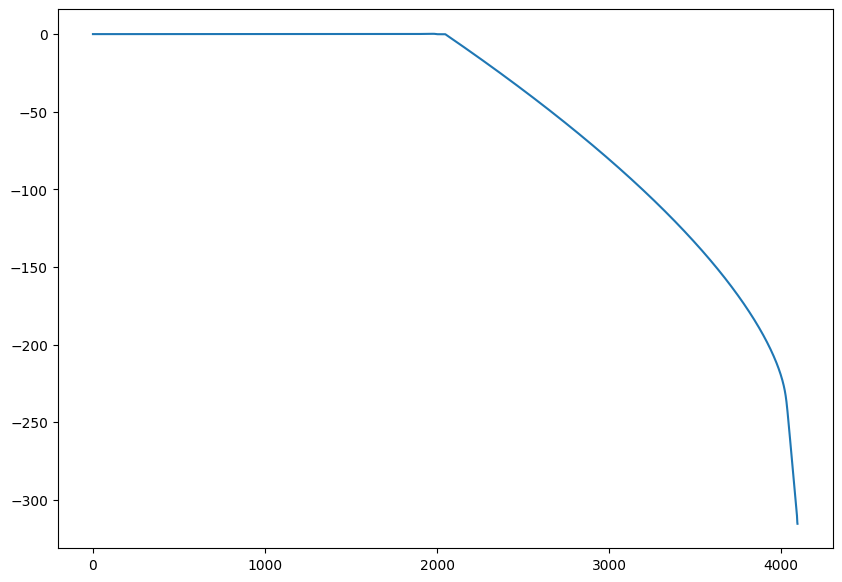

In [122]:
import matplotlib.pyplot as plt

plt.plot(a[0][0][0])

In [53]:
encoder.layers[-1].weights

<tf.Variable 'dense_52/bias:0' shape=(20,) dtype=float32, numpy=
array([-0.00684591, -0.00110382,  0.00139666, -0.00937338, -0.00423797,
       -0.00326199,  0.00469221, -0.00462598,  0.00121699, -0.00624049,
       -0.00048716,  0.00066014, -0.0006605 , -0.00169711,  0.00970985,
       -0.00914126,  0.00274246, -0.00130501, -0.00762051,  0.00835565],
      dtype=float32)>

625/625 [==============================] - 2s 3ms/step


Calculating mismatches: 100%|██████████| 20000/20000 [02:02<00:00, 162.70it/s]


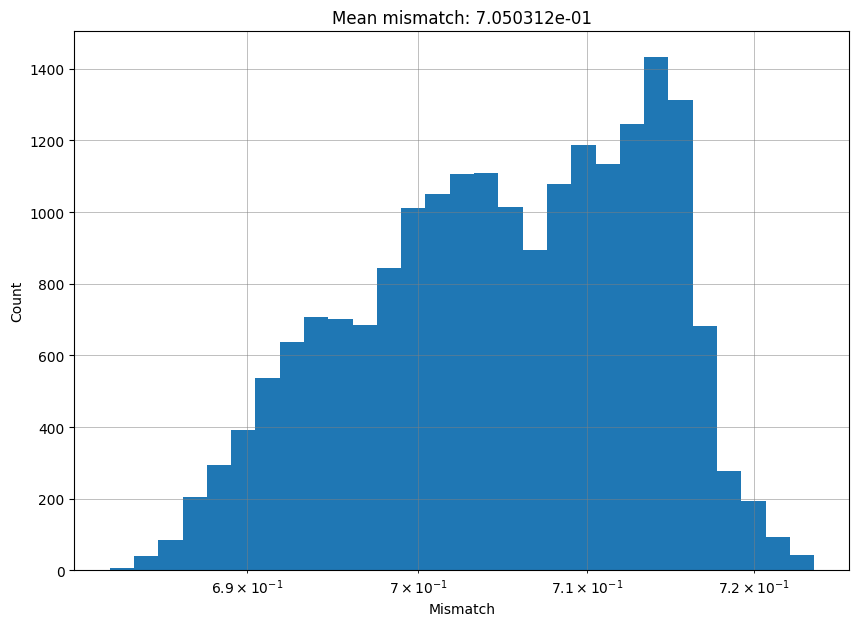

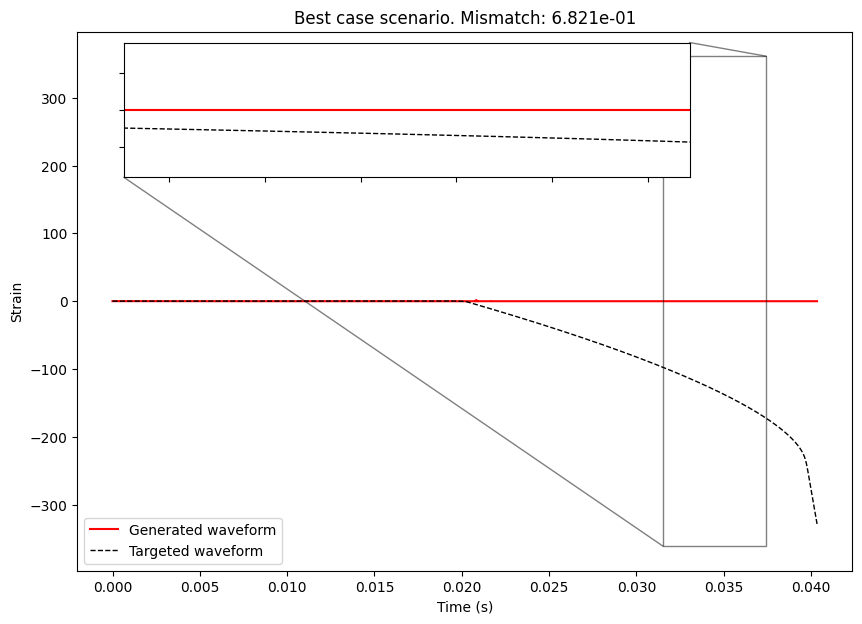

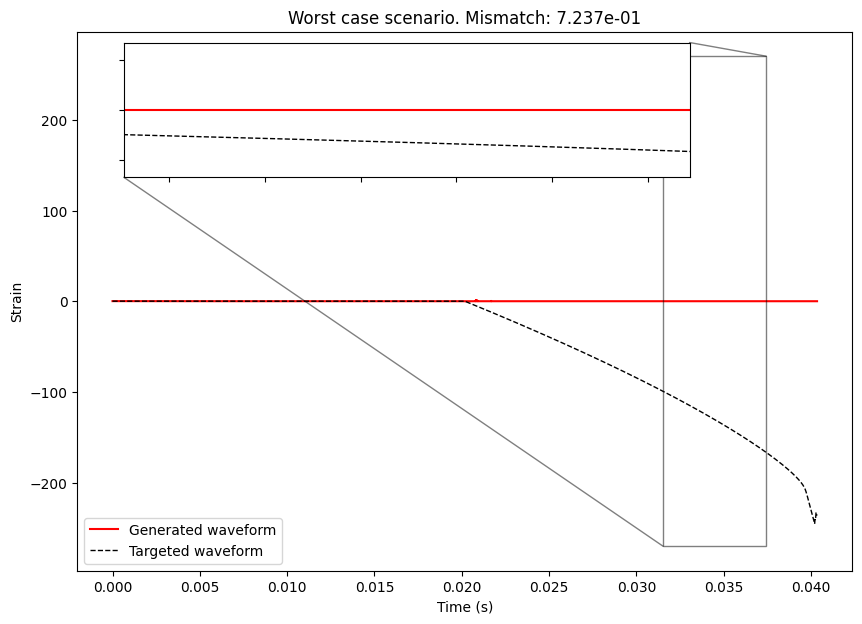

In [53]:
from utils.plot_utils import nb_evaluate_model

nb_evaluate_model(autoencoder.predict(data_loader.y_test), data_loader.y_test, data_loader.delta_t)

# Gif code

In [28]:
import os
import re

base_directory = "/home/nino/GW/Keras-Project-Template/temp/plots_pca_wise_amp_phs"  # Set the base directory

folders = []
for root, dirs, files in os.walk(base_directory):
    folders.append(root)

paths = folders[1:]

# Function to extract the number from the folder name
def extract_number(path):
    # Get the folder name from the full path
    folder_name = os.path.basename(path)
    
    # Extract the leading number using regex
    match = re.match(r'(\d+)', folder_name)
    
    # If a number is found, return it as an integer; otherwise, return 0 (default)
    return int(match.group(1)) if match else 0

# Sort the paths using the extracted number as the key
sorted_paths = sorted(paths, key=extract_number)
final_paths = []
# Output the sorted paths
for path in sorted_paths:
    path = os.path.join(path, "mismatch_histogram.png")
    final_paths.append(path)
    


In [ ]:
from PIL import Image, ImageDraw, ImageFont

def add_label_to_image(image, text, position=(10, 10), font_size=20):
    # Create an ImageDraw object to modify the image
    draw = ImageDraw.Draw(image)
    
    # Load a font; alternatively, you can specify a path to a .ttf file for custom fonts
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()  # Fallback to default font if "arial.ttf" is unavailable
    
    # Add text to the image
    draw.text(position, text, font=font, fill="white")  # You can change the fill color
    
    return image

In [29]:
from PIL import Image
import glob

# Load the images into a list
images = [Image.open(img) for img in final_paths]

# Save as an animated GIF
# The first image is the base image, the rest are appended as frames
output_path = "/home/nino/GW/Keras-Project-Template/temp/plots_pca_wise_amp_phs/output_animation.gif"
images[0].save(output_path, save_all=True, append_images=images[1:], duration=500, loop=0)

print(f"Animated GIF saved at {output_path}")


Animated GIF saved at /home/nino/GW/Keras-Project-Template/temp/plots_pca_wise_amp_phs/output_animation.gif


# Analysis of experiments

In [2]:
from utils.config import get_config_from_json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
from joblib import load
from scipy.stats import wasserstein_distance

def get_experiment_data(path):
    config, _ = get_config_from_json(os.path.join(path, 'config.json'))
    model_id = config.model.model_id
    uninit = config.trainer.uninitialised

    if isinstance(config.model.pca_n_components, str) or isinstance(config.model.pca_n_components, int):
        n_comp = config.model.pca_n_components
    else:
        n_comp = config.model.latent_dim

    if isinstance(config.model.ae_id, str):
        ae_id = config.model.ae_id
        return n_comp, model_id, uninit, ae_id

    else:
        return n_comp, model_id, uninit


def plot_mismatch_comparison(data_dict, saving_directory, title = None):

    matplotlib.rc('font', size=15)
    plt.rcParams["figure.figsize"] = (15,9)

    data = [data_dict[key] for key in data_dict.keys()]
    bins = np.logspace(np.log10(min([min(vec) for vec in data])), np.log10(max([max(vec) for vec in data])), num=30)

    for key in data_dict.keys():

        _ = plt.hist(data_dict[key], bins = bins, histtype='step', label = f"{key}.  $\\mu$ = {np.mean(data_dict[key]):.2e}")

    plt.legend()
    plt.grid(True, which="both", axis="both", linestyle='-', color='gray', linewidth=0.5, alpha = 0.7)
    plt.xscale('log')

    if title is None:
        plt.title("Mismatch comparison")
    else:
        plt.title(title)
        
    plt.ylabel('Count')
    plt.xlabel('Mismatch')
    plt.savefig(saving_directory)
    plt.close()

def get_wass_dist(dict):
    
    keys_uninit = []
    keys = []
    w_dist = []

    for key in dict.keys():

        if 'uninit' in key:
            keys_uninit.append(key)
        else:
            keys.append(key)

    assert len(keys) == len(keys_uninit), "Dictionary contains a different number of initialised and uninitialised models."

    for k_un, k in zip(keys_uninit, keys):

        w_dist.append(wasserstein_distance(dict[k_un], dict[k]))

    return np.mean(w_dist)

def get_mean_mismatches(dict):
    
    mean_mms = {}

    for key in dict.keys():
        mean_mms[key] = np.mean(dict[key])

    return mean_mms

## PCA experiments analysis

In [2]:
# Mismatch vector gathering for each experiment

pca_experiments_path = "/home/nino/GW/Keras-Project-Template/experiments/pca_experiments"
mismatches_dict = {}

for experiment in os.listdir(pca_experiments_path):

    if experiment == 'figures':
        continue

    path = os.path.join(pca_experiments_path, experiment)
    path = os.path.join(path, os.listdir(path)[0])
    n_comp, model_id, uninit = get_experiment_data(os.path.join(path, 'checkpoints'))
    mismatch = load(os.path.join(path, "figures/mismatches_test.bin"))

    if uninit:
        if f'ID_{model_id}_n_comp_{n_comp}_uninit' in mismatches_dict.keys():
            key = f'ID_{model_id}_n_comp_{n_comp}_uninit_r'
        else:
            key = f'ID_{model_id}_n_comp_{n_comp}_uninit'

        mismatches_dict[key] = mismatch
    else:
        if f'ID_{model_id}_n_comp_{n_comp}' in mismatches_dict.keys():
            key = f'ID_{model_id}_n_comp_{n_comp}_r'
        else:
            key = f'ID_{model_id}_n_comp_{n_comp}'

        mismatches_dict[key] = mismatch

In [59]:
# Mismatch vector gathering for each experiment

pca_experiments_path = "/home/nino/GW/Keras-Project-Template/experiments/pca_experiments"
mismatches_dict_tl_ts = {}
mismatches_dict_tl_val = {}

for experiment in os.listdir(pca_experiments_path):

    if experiment == 'figures':
        continue

    path = os.path.join(pca_experiments_path, experiment)
    path = os.path.join(path, os.listdir(path)[0])
    n_comp, model_id, uninit = get_experiment_data(os.path.join(path, 'checkpoints'))
    mismatch_ts = load(os.path.join(path, "transfer_learning_overlap/tl_figures/mismatches_test.bin"))
    mismatch_val = load(os.path.join(path, "transfer_learning_overlap/tl_figures/mismatches_validation.bin"))

    if uninit:
        if f'ID_{model_id}_n_comp_{n_comp}_uninit' in mismatches_dict_tl_ts.keys():
            key = f'ID_{model_id}_n_comp_{n_comp}_uninit_r'
        else:
            key = f'ID_{model_id}_n_comp_{n_comp}_uninit'
        

        mismatches_dict_tl_ts[key] = mismatch_ts
        mismatches_dict_tl_val[key] = mismatch_val
    else:
        if f'ID_{model_id}_n_comp_{n_comp}' in mismatches_dict_tl_ts.keys():
            key = f'ID_{model_id}_n_comp_{n_comp}_r'
        else:
            key = f'ID_{model_id}_n_comp_{n_comp}'


        mismatches_dict_tl_ts[key] = mismatch_ts
        mismatches_dict_tl_val[key] = mismatch_val
    

In [20]:
mismatches_dict.keys()

dict_keys(['ID_1_n_comp_15', 'ID_0_n_comp_5_uninit', 'ID_0_n_comp_5_uninit_r', 'ID_1_n_comp_5', 'ID_0_n_comp_5', 'ID_0_n_comp_15_uninit', 'ID_3_n_comp_15_uninit', 'ID_3_n_comp_5_uninit', 'ID_0_n_comp_5_r', 'ID_2_n_comp_15', 'ID_2_n_comp_15_uninit', 'ID_2_n_comp_5', 'ID_0_n_comp_15', 'ID_2_n_comp_5_uninit', 'ID_0_n_comp_15_r', 'ID_3_n_comp_15', 'ID_3_n_comp_5_uninit_r', 'ID_1_n_comp_5_r', 'ID_2_n_comp_15_r', 'ID_3_n_comp_15_r', 'ID_1_n_comp_15_r', 'ID_1_n_comp_5_uninit', 'ID_3_n_comp_5', 'ID_2_n_comp_5_uninit_r', 'ID_0_n_comp_15_uninit_r', 'ID_2_n_comp_15_uninit_r', 'ID_1_n_comp_15_uninit', 'ID_2_n_comp_5_r', 'ID_1_n_comp_15_uninit_r', 'ID_1_n_comp_5_uninit_r', 'ID_3_n_comp_5_r', 'ID_3_n_comp_15_uninit_r'])

In [4]:
pca_dict = {}
uninit_dict = {}
dict_0_5 = {}
dict_1_5 = {}
dict_2_5 = {}
dict_3_5 = {}
dict_0_15 = {}
dict_1_15 = {}
dict_2_15 = {}
dict_3_15 = {}

for key in mismatches_dict.keys():

    if "_uninit" in key:
        uninit_dict[key] = mismatches_dict[key]
    else:
        pca_dict[key] = mismatches_dict[key]
    if "ID_0_n_comp_5" in key:
        dict_0_5[key] = mismatches_dict[key]
    elif "ID_1_n_comp_5" in key:
        dict_1_5[key] = mismatches_dict[key]
    elif "ID_2_n_comp_5" in key:
        dict_2_5[key] = mismatches_dict[key]
    elif "ID_3_n_comp_5" in key:
        dict_3_5[key] = mismatches_dict[key]
    elif "ID_0_n_comp_15" in key:
        dict_0_15[key] = mismatches_dict[key]
    elif "ID_1_n_comp_15" in key:
        dict_1_15[key] = mismatches_dict[key]
    elif "ID_2_n_comp_15" in key:
        dict_2_15[key] = mismatches_dict[key]
    elif "ID_3_n_comp_15" in key:
        dict_3_15[key] = mismatches_dict[key]

base_path = "/home/nino/GW/Keras-Project-Template/experiments/pca_experiments/figures"


plot_mismatch_comparison(
    data_dict = pca_dict,
    saving_directory = os.path.join(base_path, "pca_models.jpeg")
    )
plot_mismatch_comparison(
    data_dict = uninit_dict,
    saving_directory = os.path.join(base_path, "uninit_models.jpeg")
    )
plot_mismatch_comparison(
    data_dict = dict_0_5,
    saving_directory = os.path.join(base_path, "id_0_n_5.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_0_5):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_1_5,
    saving_directory = os.path.join(base_path, "id_1_n_5.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_1_5):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_2_5,
    saving_directory = os.path.join(base_path, "id_2_n_5.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_2_5):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_3_5,
    saving_directory = os.path.join(base_path, "id_3_n_5.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_3_5):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_0_15,
    saving_directory = os.path.join(base_path, "id_0_n_15.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_0_15):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_1_15,
    saving_directory = os.path.join(base_path, "id_1_n_15.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_1_15):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_2_15,
    saving_directory = os.path.join(base_path, "id_2_n_15.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_2_15):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_3_15,
    saving_directory = os.path.join(base_path, "id_3_n_15.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_3_15):.3e}"
    )

In [8]:
pca_dict.keys()

dict_keys(['ID_1_n_comp_15', 'ID_1_n_comp_5', 'ID_0_n_comp_5', 'ID_0_n_comp_5_r', 'ID_2_n_comp_15', 'ID_2_n_comp_5', 'ID_0_n_comp_15', 'ID_0_n_comp_15_r', 'ID_3_n_comp_15', 'ID_1_n_comp_5_r', 'ID_2_n_comp_15_r', 'ID_3_n_comp_15_r', 'ID_1_n_comp_15_r', 'ID_3_n_comp_5', 'ID_2_n_comp_5_r', 'ID_3_n_comp_5_r'])

In [14]:
np.array(plot_vector)[:, 0]

array([1., 1., 0., 0., 2., 2., 0., 0., 3., 1., 2., 3., 1., 3., 2., 3.])

In [50]:
def get_scatter_plot(dict, save_dir, marker = "^"):
    plot_vector = []
    n_dim = []

    for key in dict.keys():

        id_ = int(key[3])
        plot_vector.append([id_, dict[key]])

        if '15' in key:
            n_dim.append('r')
        else:
            n_dim.append('b')
        

    plot_vector = np.array(plot_vector)

    matplotlib.rc('font', size=12)
    plt.rcParams["figure.figsize"] = (8,6)

    for color, label in zip(['r', 'b'], ['Latent dimension: 15', 'Latent dimension: 5']):
        mask = np.array(n_dim) == color
        _=plt.scatter(plot_vector[mask, 0], plot_vector[mask, 1], c=color, marker=marker, label=label)
    plt.xlabel("Model ID")
    plt.ylabel("Mean test mismatch")
    plt.title("Mean test mismatch vs. network architecture")
    plt.grid()
    _=plt.legend()
    plt.savefig(save_dir)
    plt.close()

In [33]:
mean_pca = get_mean_mismatches(pca_dict)
mean_uninit = get_mean_mismatches(uninit_dict)

figpath = "/home/nino/GW/Keras-Project-Template/experiments/pca_experiments/figures"

mean_pca_dir = os.path.join(figpath, "pca_models_vs_id.jpeg" )
mean_uninit_dir = os.path.join(figpath, "uninitialised_pca_models_vs_id.jpeg" )

get_scatter_plot(mean_pca, mean_pca_dir)
get_scatter_plot(mean_uninit, mean_uninit_dir)

In [53]:
mismatches_dict_tl_val.keys()

dict_keys(['ID_1_n_comp_DotMap()', 'ID_0_n_comp_DotMap()_uninit', 'ID_0_n_comp_DotMap()_uninit_r', 'ID_1_n_comp_DotMap()_r', 'ID_0_n_comp_DotMap()', 'ID_3_n_comp_DotMap()_uninit', 'ID_3_n_comp_DotMap()_uninit_r', 'ID_0_n_comp_DotMap()_r', 'ID_2_n_comp_DotMap()', 'ID_2_n_comp_DotMap()_uninit', 'ID_2_n_comp_DotMap()_r', 'ID_2_n_comp_DotMap()_uninit_r', 'ID_3_n_comp_DotMap()', 'ID_3_n_comp_DotMap()_r', 'ID_1_n_comp_DotMap()_uninit', 'ID_1_n_comp_DotMap()_uninit_r'])

In [60]:
save_dir = "/home/nino/GW/Keras-Project-Template/experiments/pca_experiments/figures/tl_test_mismatches.jpeg"
get_scatter_plot(get_mean_mismatches(mismatches_dict_tl_ts), save_dir)

save_dir = "/home/nino/GW/Keras-Project-Template/experiments/pca_experiments/figures/tl_val_mismatches.jpeg"
get_scatter_plot(get_mean_mismatches(mismatches_dict_tl_val), save_dir)

In [61]:
mismatches_dict_test_uninit = {}
mismatches_dict_val_uninit = {}
mismatches_dict_test_no_uninit = {}
mismatches_dict_val_no_uninit = {}

for key in mismatches_dict_tl_ts.keys():
    if "_uninit" in key:
        mismatches_dict_test_uninit[key] = mismatches_dict_tl_ts[key]
        mismatches_dict_val_uninit[key] = mismatches_dict_tl_val[key]
    else:
        mismatches_dict_test_no_uninit[key] = mismatches_dict_tl_ts[key]
        mismatches_dict_val_no_uninit[key] = mismatches_dict_tl_val[key]

In [62]:
save_dir = "/home/nino/GW/Keras-Project-Template/experiments/pca_experiments/figures/tl_test_mismatches_uninit.jpeg"
get_scatter_plot(get_mean_mismatches(mismatches_dict_test_uninit), save_dir)

save_dir = "/home/nino/GW/Keras-Project-Template/experiments/pca_experiments/figures/tl_val_mismatches_uninit.jpeg"
get_scatter_plot(get_mean_mismatches(mismatches_dict_val_uninit), save_dir)

save_dir = "/home/nino/GW/Keras-Project-Template/experiments/pca_experiments/figures/tl_test_mismatches_no_uninit.jpeg"
get_scatter_plot(get_mean_mismatches(mismatches_dict_test_no_uninit), save_dir)

save_dir = "/home/nino/GW/Keras-Project-Template/experiments/pca_experiments/figures/tl_val_mismatches_no_uninit.jpeg"
get_scatter_plot(get_mean_mismatches(mismatches_dict_val_no_uninit), save_dir)

## AE experiments analysis

In [2]:
# Fixing missing data

pca_experiments_path = "/home/nino/GW/Keras-Project-Template/experiments/pca_experiments"
bad_models = []
for experiment in os.listdir(pca_experiments_path):

    if experiment == 'figures':
        continue

    path = os.path.join(pca_experiments_path, experiment)
    try:
        path = os.path.join(path, os.listdir(path)[0])
    except:
        print(path)

    try:     
        mismatch = load(os.path.join(path, "figures/mismatches_test.bin"))
    except:
        bad_models.append(path)

[]

In [47]:
# Mismatch vector gathering for each experiment

pca_experiments_path = "/home/nino/GW/Keras-Project-Template/experiments/ae_experiments"
mismatches_dict = {}
bad_modls_2 = []

for experiment in os.listdir(pca_experiments_path):

    if experiment == 'figures':
        continue

    path = os.path.join(pca_experiments_path, experiment)
    path = os.path.join(path, os.listdir(path)[0])
    n_comp, model_id, uninit, ae_id = get_experiment_data(os.path.join(path, 'checkpoints'))
    mismatch = load(os.path.join(path, "figures/mismatches_test.bin"))

    if uninit:
        if f'ID_{model_id}_aeID_{ae_id}_n_comp_{n_comp}_uninit' in mismatches_dict.keys():
            key = f'ID_{model_id}_aeID_{ae_id}_n_comp_{n_comp}_uninit_r'
        else:
            key = f'ID_{model_id}_aeID_{ae_id}_n_comp_{n_comp}_uninit'
        

        mismatches_dict[key] = mismatch
    else:
        if f'ID_{model_id}_aeID_{ae_id}_n_comp_{n_comp}' in mismatches_dict.keys():
            key = f'ID_{model_id}_aeID_{ae_id}_n_comp_{n_comp}_r'
        else:
            key = f'ID_{model_id}_aeID_{ae_id}_n_comp_{n_comp}'


        mismatches_dict[key] = mismatch
    
    if 'uninit' not in path and uninit == True:
        bad_modls_2.append(path)
    
print(len(bad_modls_2))
bad_modls_2.sort()
bad_modls_2

In [4]:
ae_dict = {}
uninit_dict = {}
dict_0_0_5 = {}
dict_1_0_5 = {}
dict_2_0_5 = {}
dict_3_0_5 = {}
dict_0_1_5 = {}
dict_1_1_5 = {}
dict_2_1_5 = {}
dict_3_1_5 = {}
dict_0_0_15 = {}
dict_1_0_15 = {}
dict_2_0_15 = {}
dict_3_0_15 = {}
dict_0_1_15 = {}
dict_1_1_15 = {}
dict_2_1_15 = {}
dict_3_1_15 = {}

for key in mismatches_dict.keys():

    if "_uninit" in key:
        uninit_dict[key] = mismatches_dict[key]
    else:
        ae_dict[key] = mismatches_dict[key]
        
    if "ID_0_aeID_0_n_comp_5" in key:
        dict_0_0_5[key] = mismatches_dict[key]
    elif "ID_1_aeID_0_n_comp_5" in key:
        dict_1_0_5[key] = mismatches_dict[key]
    elif "ID_2_aeID_0_n_comp_5" in key:
        dict_2_0_5[key] = mismatches_dict[key]
    elif "ID_3_aeID_0_n_comp_5" in key:
        dict_3_0_5[key] = mismatches_dict[key]
    elif "ID_0_aeID_1_n_comp_5" in key:
        dict_0_1_5[key] = mismatches_dict[key]
    elif "ID_1_aeID_1_n_comp_5" in key:
        dict_1_1_5[key] = mismatches_dict[key]
    elif "ID_2_aeID_1_n_comp_5" in key:
        dict_2_1_5[key] = mismatches_dict[key]
    elif "ID_3_aeID_1_n_comp_5" in key:
        dict_3_1_5[key] = mismatches_dict[key]
    elif "ID_0_aeID_0_n_comp_15" in key:
        dict_0_0_15[key] = mismatches_dict[key]
    elif "ID_1_aeID_0_n_comp_15" in key:
        dict_1_0_15[key] = mismatches_dict[key]
    elif "ID_2_aeID_0_n_comp_15" in key:
        dict_2_0_15[key] = mismatches_dict[key]
    elif "ID_3_aeID_0_n_comp_15" in key:
        dict_3_0_15[key] = mismatches_dict[key]
    elif "ID_0_aeID_1_n_comp_15" in key:
        dict_0_1_15[key] = mismatches_dict[key]
    elif "ID_1_aeID_1_n_comp_15" in key:
        dict_1_1_15[key] = mismatches_dict[key]
    elif "ID_2_aeID_1_n_comp_15" in key:
        dict_2_1_15[key] = mismatches_dict[key]
    elif "ID_3_aeID_1_n_comp_15" in key:
        dict_3_1_15[key] = mismatches_dict[key]

base_path = "/home/nino/GW/Keras-Project-Template/experiments/ae_experiments/figures"


plot_mismatch_comparison(
    data_dict = ae_dict,
    saving_directory = os.path.join(base_path, "pca_models.jpeg")
    )
plot_mismatch_comparison(
    data_dict = uninit_dict,
    saving_directory = os.path.join(base_path, "uninit_models.jpeg")
    )
plot_mismatch_comparison(
    data_dict = dict_0_0_5,
    saving_directory = os.path.join(base_path, "id_0_ae_0_n_5.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_0_0_5):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_1_0_5,
    saving_directory = os.path.join(base_path, "id_1_ae_0_n_5.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_1_0_5):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_2_0_5,
    saving_directory = os.path.join(base_path, "id_2_ae_0_n_5.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_2_0_5):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_3_0_5,
    saving_directory = os.path.join(base_path, "id_3_ae_0_n_5.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_3_0_5):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_0_1_5,
    saving_directory = os.path.join(base_path, "id_0_ae_1_n_5.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_0_1_5):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_1_1_5,
    saving_directory = os.path.join(base_path, "id_1_ae_1_n_5.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_1_1_5):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_2_1_5,
    saving_directory = os.path.join(base_path, "id_2_ae_1_n_5.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_2_1_5):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_3_1_5,
    saving_directory = os.path.join(base_path, "id_3_ae_1_n_5.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_3_1_5):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_0_0_15,
    saving_directory = os.path.join(base_path, "id_0_ae_0_n_15.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_0_0_15):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_1_0_15,
    saving_directory = os.path.join(base_path, "id_1_ae_0_n_15.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_1_0_15):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_2_0_15,
    saving_directory = os.path.join(base_path, "id_2_ae_0_n_15.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_2_0_15):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_3_0_15,
    saving_directory = os.path.join(base_path, "id_3_ae_0_n_15.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_3_0_15):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_0_1_15,
    saving_directory = os.path.join(base_path, "id_0_ae_1_n_15.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_0_1_15):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_1_1_15,
    saving_directory = os.path.join(base_path, "id_1_ae_1_n_15.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_1_1_15):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_2_1_15,
    saving_directory = os.path.join(base_path, "id_2_ae_1_n_15.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_2_1_15):.3e}"
    )
plot_mismatch_comparison(
    data_dict = dict_3_1_15,
    saving_directory = os.path.join(base_path, "id_3_ae_1_n_15.jpeg"),
    title = f"Mismatch comparison. Wasserstein distance = {get_wass_dist(dict_3_1_15):.3e}"
    )

In [48]:
import re

def get_architecture_from_keys(dictionary):
    ids = []
    keys = dictionary.keys()

    for key in keys:
        numbers = re.findall(r'\d+', key)
        if numbers[2] == '15':
            numbers[2] = 'r'
        else:
            numbers[2] = 'b'

        if numbers[1] == '0':
            numbers[1] = 'v'
        else:
            numbers[1] = "*"

        ids.append(numbers)   
    return np.array(ids)

# get_architecture_from_keys(ae_dict)

In [40]:
def get_scatter_plot(dict, save_dir):
    plot_vector = []

    ids = get_architecture_from_keys(dict)

    for key, model_id in zip(dict.keys(), ids):

        id_ = int(model_id[0])
        plot_vector.append([id_, dict[key]])        

    plot_vector = np.array(plot_vector)

    matplotlib.rc('font', size=10)
    plt.rcParams["figure.figsize"] = (10,8)

    for color, lab_col in zip(['r', 'b'], [15, 5]):
        for shape, lab_shape in zip(['v', '*'], [0, 1]):

            label = f"AE arch.: {lab_shape}. Lat. dim.: {lab_col}"
            mask = np.logical_and(ids[:, 1] == shape, ids[:, 2] == color)
            _=plt.scatter(plot_vector[mask, 0], plot_vector[mask, 1], c=color, marker=shape, label=label)
        
    plt.xlabel("Model ID")
    plt.ylabel("Mean test mismatch")
    plt.title("Mean test mismatch vs. network architecture")
    plt.grid()
    _=plt.legend()
    plt.savefig(save_dir)
    plt.close()

In [30]:
save_dir = "/home/nino/GW/Keras-Project-Template/experiments/ae_experiments/figures/ae_mean_mismatches.jpeg"

get_scatter_plot(get_mean_mismatches(ae_dict), save_dir)

In [31]:
save_dir = "/home/nino/GW/Keras-Project-Template/experiments/ae_experiments/figures/uninit_mean_mismatches.jpeg"

get_scatter_plot(get_mean_mismatches(uninit_dict), save_dir = save_dir)

## Transfer learning

In [37]:
pca_experiments_path = "/home/nino/GW/Keras-Project-Template/experiments/ae_experiments"
mismatches_dict_test = {}
mismatches_dict_val = {}

for experiment in os.listdir(pca_experiments_path):

    if experiment == 'figures':
        continue

    path = os.path.join(pca_experiments_path, experiment)
    path = os.path.join(path, os.listdir(path)[0])
    n_comp, model_id, uninit, ae_id = get_experiment_data(os.path.join(path, 'checkpoints'))
    mismatch_ts = load(os.path.join(path, "transfer_learning_overlap/tl_figures/mismatches_test.bin"))
    mismatch_val = load(os.path.join(path, "transfer_learning_overlap/tl_figures/mismatches_validation.bin"))

    if uninit:
        if f'ID_{model_id}_aeID_{ae_id}_n_comp_{n_comp}_uninit' in mismatches_dict_test.keys():
            key = f'ID_{model_id}_aeID_{ae_id}_n_comp_{n_comp}_uninit_r'
        else:
            key = f'ID_{model_id}_aeID_{ae_id}_n_comp_{n_comp}_uninit'
        

        mismatches_dict_test[key] = mismatch_ts
        mismatches_dict_val[key] = mismatch_val
    else:
        if f'ID_{model_id}_aeID_{ae_id}_n_comp_{n_comp}' in mismatches_dict_test.keys():
            key = f'ID_{model_id}_aeID_{ae_id}_n_comp_{n_comp}_r'
        else:
            key = f'ID_{model_id}_aeID_{ae_id}_n_comp_{n_comp}'


        mismatches_dict_test[key] = mismatch_ts
        mismatches_dict_val[key] = mismatch_val

In [43]:
mismatches_dict_test_uninit = {}
mismatches_dict_val_uninit = {}
mismatches_dict_test_no_uninit = {}
mismatches_dict_val_no_uninit = {}

for key in mismatches_dict_test.keys():
    if "_uninit" in key:
        mismatches_dict_test_uninit[key] = mismatches_dict_test[key]
        mismatches_dict_val_uninit[key] = mismatches_dict_val[key]
    else:
        mismatches_dict_test_no_uninit[key] = mismatches_dict_test[key]
        mismatches_dict_val_no_uninit[key] = mismatches_dict_val[key]

In [44]:
save_dir = "/home/nino/GW/Keras-Project-Template/experiments/ae_experiments/figures/ae_mean_test_mismatches_transfer_learning_uninit.jpeg"

get_scatter_plot(get_mean_mismatches(mismatches_dict_test_uninit), save_dir)

save_dir = "/home/nino/GW/Keras-Project-Template/experiments/ae_experiments/figures/ae_mean_val_mismatches_transfer_learning_uninit.jpeg"

get_scatter_plot(get_mean_mismatches(mismatches_dict_val_uninit), save_dir)

save_dir = "/home/nino/GW/Keras-Project-Template/experiments/ae_experiments/figures/ae_mean_test_mismatches_transfer_learning_no_uninit.jpeg"

get_scatter_plot(get_mean_mismatches(mismatches_dict_test_no_uninit), save_dir)

save_dir = "/home/nino/GW/Keras-Project-Template/experiments/ae_experiments/figures/ae_mean_val_mismatches_transfer_learning_no_uninit.jpeg"

get_scatter_plot(get_mean_mismatches(mismatches_dict_val_no_uninit), save_dir)

In [41]:
save_dir = "/home/nino/GW/Keras-Project-Template/experiments/ae_experiments/figures/ae_mean_test_mismatches_transfer_learning.jpeg"

get_scatter_plot(get_mean_mismatches(mismatches_dict_test), save_dir)

In [42]:
save_dir = "/home/nino/GW/Keras-Project-Template/experiments/ae_experiments/figures/ae_mean_validation_mismatches_transfer_learning.jpeg"

get_scatter_plot(get_mean_mismatches(mismatches_dict_val), save_dir)

## Retraining exploration

In [ ]:
def get_next_level(path):

    return os.path.join(path, os.listdir(path)[0])

In [4]:
from joblib import load

path = "/home/nino/GW/Keras-Project-Template/experiments"
comparison_dict = {}

for model_type in os.listdir(path):
    path_ = os.path.join(path, model_type)

    for exp in os.listdir(path_):
        
        model_dir = os.path.join(path_, exp)
        model_id = os.listdir(model_dir)[0]
        model_dir = os.path.join(model_dir, model_id)

        try:
            
            mm = load(os.path.join(model_dir, "figures/mismatches_test.bin"))
            mm_retrain = load(os.path.join(model_dir, "retraining_overlap/retrain_figures/mismatches_test.bin"))

            comparison_dict[model_id] = wasserstein_distance(mm, mm_retrain)

            plot_mismatch_comparison({"Og test mismatch": mm, "Retrained test mismatch": mm_retrain}, os.path.join(model_dir, "retraining_overlap/retrain_figures/mismatch_improvement.jpeg"), "Mismatch improvement after retraining")
        except:

            continue

ValueError: If using all scalar values, you must pass an index

In [5]:
import pandas as pd

pd.DataFrame(data = comparison_dict.values(), index = list(comparison_dict.keys()))

,0
qz_ae_ldim5_mapid0_aeid1,0.000170
qz_ae_ldim5_mapid1_aeid1,0.040378
qz_ae_ldim5_mapid2_aeid0,0.000301
qz_ae_ldim15_mapid3_aeid0,0.000802
qz_ae_ldim15_mapid2_aeid0,0.000864
qz_ae_ldim15_mapid1_aeid0,0.000297
qz_ae_ldim15_mapid2_aeid1,0.000104
qz_ae_ldim5_mapid0_aeid0,0.000277
qz_ae_ldim15_mapid0_aeid0,0.000342
qz_ae_ldim5_mapid3_aeid0,0.000733


In [24]:
import os
from utils.config import process_config, init_obj
import data_loader.gw_dataloader as data_loader_module
import models.gw_models as models_module

def load_model_and_data_loader(model_dir):

    try:

        config, _ = process_config(os.path.join(model_dir, "config.json"))
    except:

        config, _ = process_config(os.path.join(os.path.dirname(model_dir), "config.json"))

    print("Loading data...", end="\r")
    data_loader = init_obj(config, "data_loader", data_loader_module)

    if config.model.name == "RegularizedAutoEncoderGenerator":
        model = init_obj(config, "model", models_module, data_loader = data_loader, inference = True)
    else:
        model = init_obj(config, "model", models_module, data_loader = data_loader)

    print("Loading model...     ", end="\r")
    model.autoencoder.autoencoder.load_weights(os.path.join(model_dir, "best_autoencoder.hdf5"))

    return model.autoencoder.autoencoder, data_loader

In [25]:
model_dir = "/home/nino/GW/Keras-Project-Template/experiments/ae_experiments/2024-09-22_18-55-17/qz_ae_ldim5_mapid0_aeid0/checkpoints"

autoencoder, data_loader = load_model_and_data_loader(model_dir)

In [26]:
ae_pred = autoencoder.predict(data_loader.y_test)

625/625 [==============================] - 3s 2ms/step


Calculating mismatches: 100%|██████████| 20000/20000 [01:47<00:00, 186.66it/s]


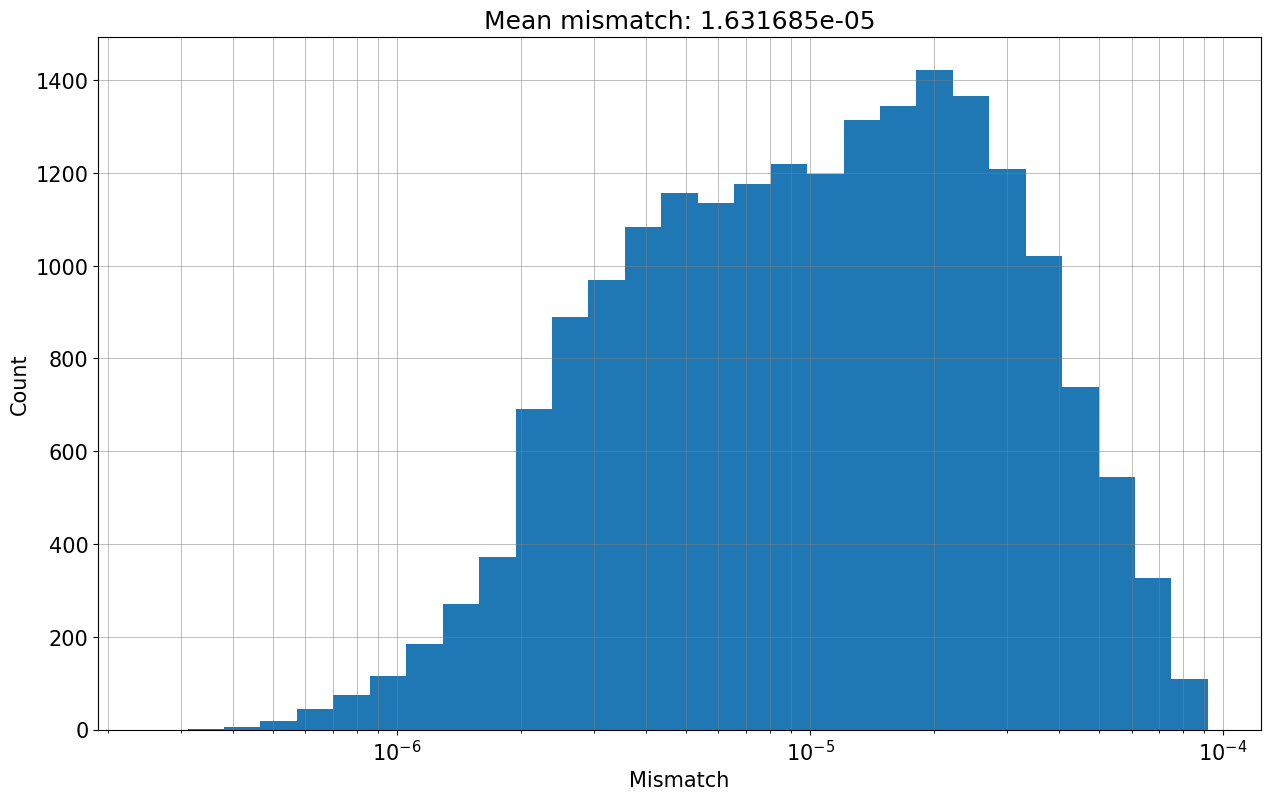

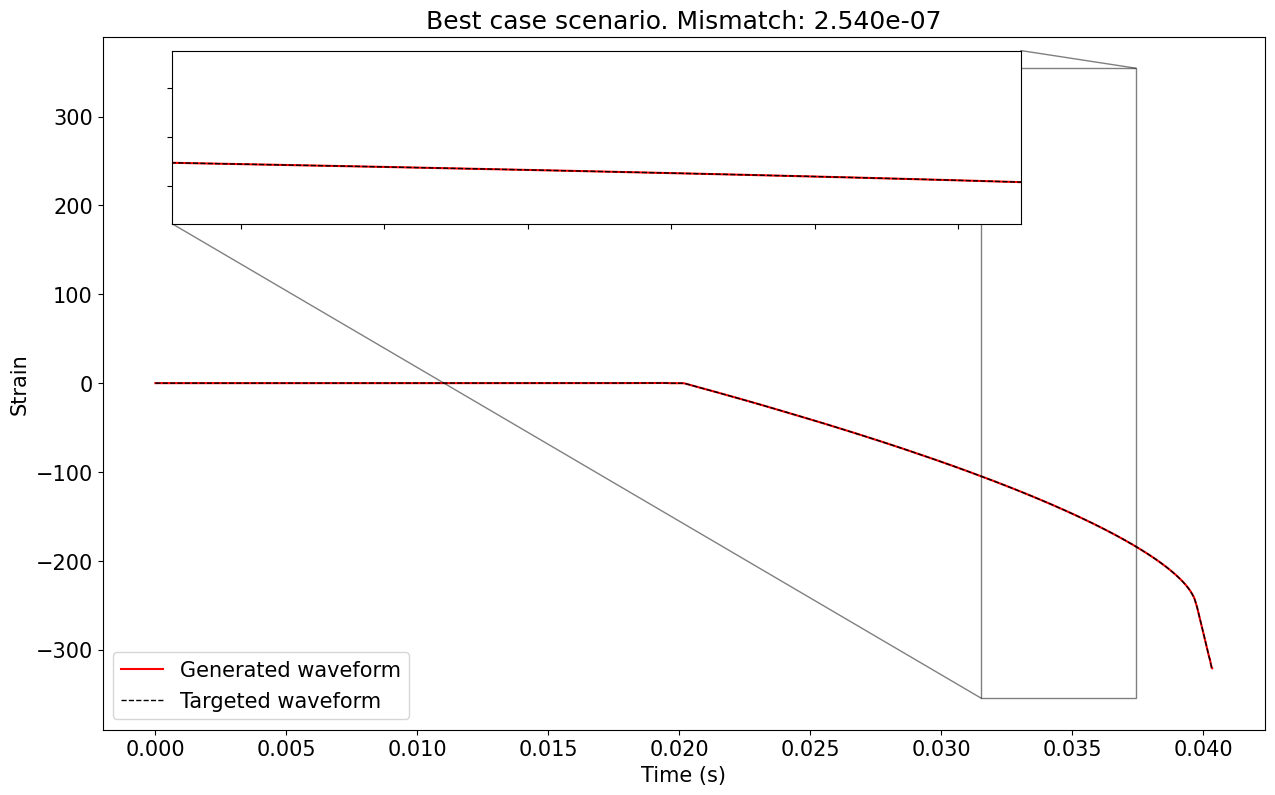

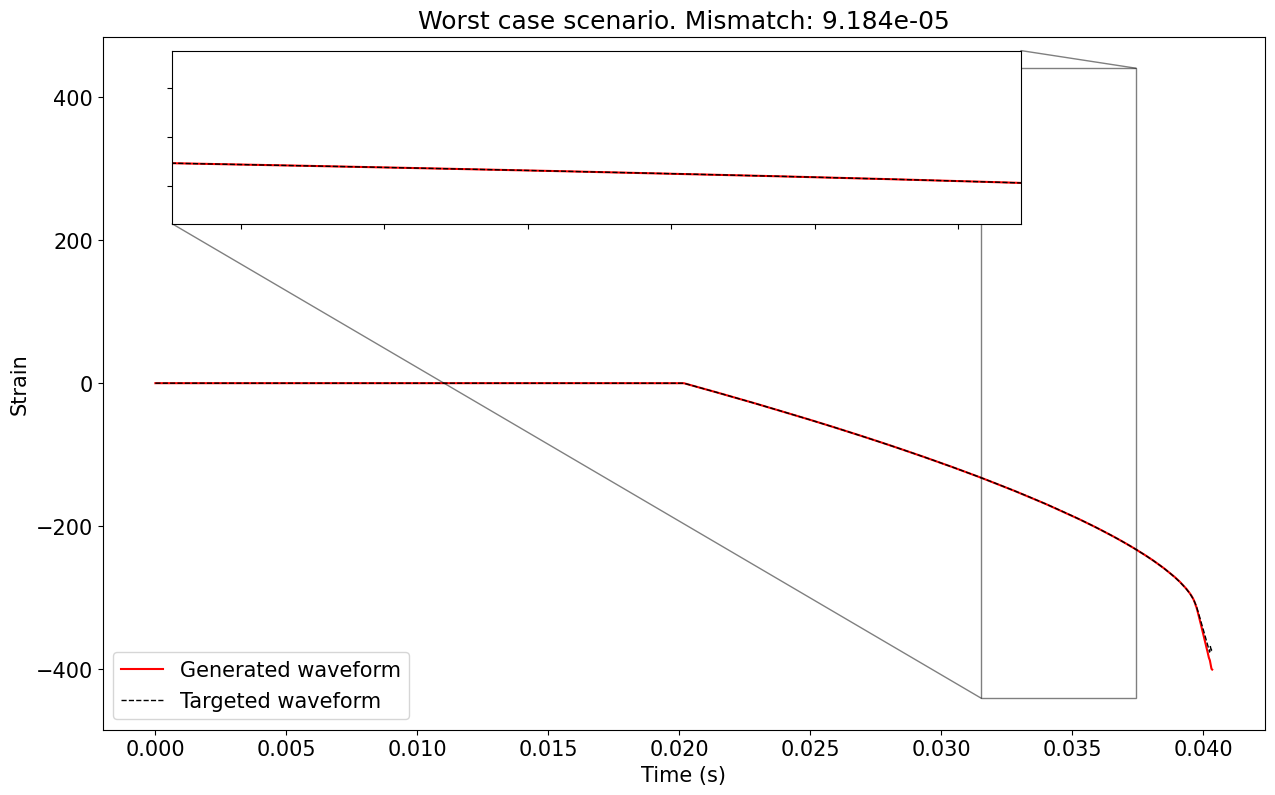

In [27]:
from utils.plot_utils import nb_evaluate_model

nb_evaluate_model(ae_pred, data_loader.y_test, data_loader.delta_t)

# Stellar astrophysics exercices

In [1]:
import numpy as np

M_sun = 1.9891e30 # Kg
R_sun = 696340000 # m
G =  6.6743e-11 # m3 kg-1 s-2

(4*np.pi*4000e-24*(1.496e8)**2*3.154e7)/(2e33*10**(-6))

1.774045424382286e-23

In [2]:
np.sqrt(2*M_sun*G/R_sun)

617497.9167791922

In [5]:
rho = 1e7 # amu/m^3
r = 149597870700 # m
v = 400000 # m/s
kg_amu = 1.67377e-27 # kg/amu
kg_msun = 1.9891e30 # kg/msun
s_yr = 3.154e+7 # s/yr

4*np.pi*rho*r*r*v*kg_amu*s_yr/(kg_msun)

2.985530625416907e-14

In [7]:
2.06264e6


2062640.0

In [6]:
1/4.84814e-6

206264.67057469464

In [2]:
import numpy as np

asec_rad = 1/(3600*180/np.pi)
sig = 5.6703e-8
f = 5e-8

((((2/0.02)/asec_rad)**2)*(f/sig))**(1/4)

4401.0221918157495

In [1]:
import numpy as np

R = 10000 # m
r = 2000 # pc
fn = 2e-25 # W m-2 Hz-1
h = 6.62607015e-34 # m2 kg / s
kb = 1.380649e-23 # m2 kg s-2 K-1
c = 299792458 # m / s
m_pc = 3.086e16 # m / pc
n = 1e8 # Hz
alpha = (2*R)/(r*m_pc)
r_pc = r * m_pc

log_val = (h*np.pi*n*n*n*alpha*alpha)/(2*c*c*fn)
T_b = (h*n)/(kb*log_val)
# exp_arg = np.pi*h*alpha*alpha*n*n*n/(2*c*c) + 1
# h*n/(kb*np.log(exp_arg))

In [2]:
print(f"{log_val:.5e}")

6.08013e-33


In [30]:
(n/(np.log((np.pi*alpha*alpha*h*n*n*n)/(2*c**2)+1)*kb))*h

1.8802846785407521e+18

In [8]:
print(f"{exp_arg:.4e}")

1.2160e+11


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

First plot

In [27]:
x = [-0.9621449353703734, -0.9621449353703734, -0.7974762592289788, -0.8020503212648525, -0.5550474815420424, -0.5184542872979266, -0.5184542872979266, -0.3812303323503369, -0.24858043943862118, -0.24858043943862118, -0.2714510985965527, -0.21656165620894263, -0.14794967873514753, -0.10678242245515834, -0.15709780280689478, -0.04731856905311016, -0.07476363922547913, -0.07476363922547913, -0.019873847859305238, -0.03817044498136335, -0.015299785823431833, -0.04731856905311016, -0.03817044498136335, -0.015299785823431833, 0.07160878877242127, 0.07160878877242127, 0.07160878877242127, 0.08075691284416786, 0.08533097488004127, 0.08075691284416786, 0.12649823116003156, 0.1356467042103422, 0.12649823116003156, 0.14479482828208967, 0.14479482828208967, 0.02586747045655824, 0.08533097488004127, 0.08990538589447872, 0.08990538589447872, 0.08990538589447872, 0.14936889031796308, 0.14936889031796308, 0.17681361151176778, 0.17681361151176778, 0.1996842706696993, 0.14479482828208967, 0.1996842706696993, 0.23627746491381552, 0.1859620845620784, 0.18138802252620523, 0.1996842706696993, 0.23627746491381552, 0.2637221861076209, 0.2591481240717468, 0.2545740620358736, 0.2545740620358736, 0.1996842706696993, 0.314037566459358, 0.3094635044234839, 0.2682962481434943, 0.2682962481434943, 0.3094635044234839, 0.3369082256172893, 0.3506307607034733, 0.31861197747379455, 0.31861197747379455, 0.364353295789658, 0.3369082256172893, 0.3094635044234839, 0.3094635044234839, 0.3323341635814152, 0.364353295789658, 0.3231860395096686, 0.364353295789658, 0.364353295789658, 0.364353295789658, 0.3231860395096686, 0.41009461410552106, 0.41009461410552106, 0.44668745937107324, 0.44668745937107324, 0.432965273263453, 0.41924273817726787, 0.41924273817726787, 0.3826495439331523, 0.3506307607034733, 0.5381700960027997, 0.6205046085627788, 0.6205046085627788, 0.5610407551607313, 0.5930598873689741, 0.6570974538283312, 0.6708199889145159, 0.6708199889145159, 0.7211353692662521, 0.6708199889145159, 0.702838772144194, 0.7257094313021255, 0.7257094313021255, 0.7257094313021255, 0.7851732847041737, 0.771450749617989, 0.771450749617989, 0.7943214087759205, 0.9223972396517623, 0.9589904338958795, 1.073343729685537, 1.1373812961448937, 1.2334383437910577, 1.2334383437910577, 1.3340691044945314, 1.361513825688337]
y = [-3, -2.834805881191624, -2.2941700624745986, -2.2491166001827043, -1.8586574614291405, -1.7084807814656804, -1.7084807814656804, -1.618374429760462, -1.1378095121802494, -1.1378095121802494, -0.9876328322167902, -0.8674910299431673, -0.9575973816483847, -0.777386396873661, -0.2818023218128185, -0.32685635698328364, -0.371908100639466, -0.371908100639466, -0.20671398183108902, -0.23674943239949586, -0.191696542986171, -0.11660820300444241, 0.0636039275274225, -0.191696542986171, 0.22879861921437028, 0.10865738981931683, 0.10865738981931683, 0.30388695919609976, 0.36395728745434086, 0.36395728745434086, 0.3939927380227477, 0.3939927380227477, 0.43904562743607034, 0.48409908972796467, 0.48409908972796467, 0.49911652857288313, 0.6793286591047476, 0.7243815485180716, 0.7243815485180716, 0.7243815485180716, 0.6192577579679361, 0.6793286591047476, 0.7093641096731536, 0.6342757696914241, 0.6342757696914241, 0.784452449654883, 0.6342757696914241, 0.799469888499801, 0.829505339068207, 0.9346291296183433, 0.994699457876584, 0.799469888499801, 0.9045936790499365, 1.02473490844499, 0.994699457876584, 0.994699457876584, 0.994699457876584, 1.1148406872716379, 1.1148406872716379, 1.2349824895452608, 1.2349824895452608, 1.2199644778217733, 1.3551237189403142, 1.4001766083536378, 1.3851591695087198, 1.3851591695087198, 1.490282387180284, 1.5353358494721787, 1.5353358494721787, 1.5053003989037732, 1.5053003989037732, 1.5203178377486912, 1.5954061777304211, 1.6104241894539086, 1.6254416282988267, 1.5803887388855022, 1.5954061777304211, 1.5803887388855022, 1.5803887388855022, 1.5803887388855022, 1.6855125294356377, 1.9408124270706617, 1.7906357471072027, 1.7906357471072027, 1.7906357471072027, 1.7606008694173676, 2.0909891070341207, 2.3763250281161223, 2.3763250281161223, 2.4814488186662578, 2.5265017080795813, 2.4664308069427694, 2.6166072004669436, 2.7067138386114458, 2.7067138386114458, 2.7067138386114458, 2.826855068006499, 2.9169605603938615, 2.977031747969959, 2.977031747969959, 3.202296767915146, 3.1572438785018226, 3.1422255803390495, 3.322438283749486, 3.547703303694674, 3.6978796972188475, 4.133392298264308, 4.283568978227767, 4.643992379973641, 4.643992379973641, 4.929328587494926, 5.06448739895454]

data = np.array([y, x]).reshape(-1, 1)

lr = LinearRegression(fit_intercept=False)
lr.fit(np.array(x).reshape(-1, 1), y)

print(f"Fitted regression: y = {lr.coef_[0]:.4f}x\nR^2 value:         {r2_score(y, lr.predict(np.array(x).reshape(-1, 1))):.5f}")

Fitted regression: y = 3.8233x
R^2 value:         0.97754


NameError: name 'lr' is not defined

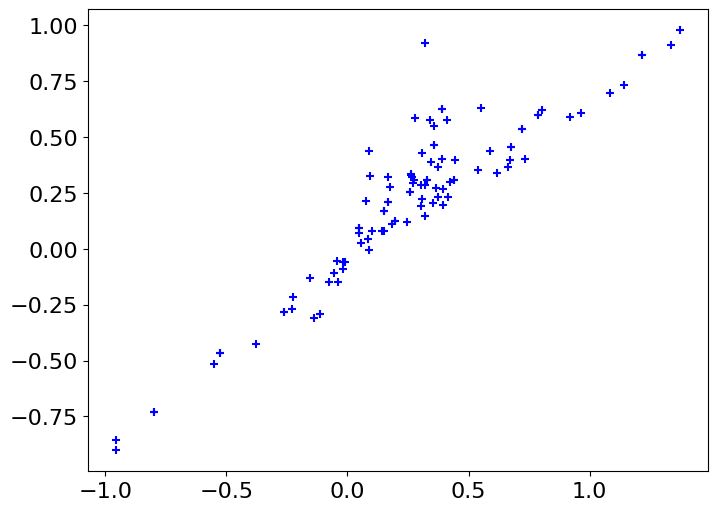

In [3]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', size=16)
plt.rcParams["figure.figsize"] = (8,6)

plt.scatter(x, y, color='blue', marker='+', label='Data Points')

# Generate values for the line with slope m and passing through the origin
x_line = np.linspace(min(x), max(x), 100)
y_line = lr.coef_[0] * x_line

# Plot the line with slope m
plt.plot(x_line, y_line, color='red', label=f'Best fit. Slope: {lr.coef_[0]:.4f}')

# Add labels and legend
plt.xlabel('log(M/M$_\odot$)')
plt.ylabel('log(L/L$_\odot$)')
plt.title(f"R$^2$ of fit: {r2_score(y, lr.predict(np.array(x).reshape(-1, 1))):.4f}")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [4]:
x = [-0.9544658481702345, -0.9544658481702345, -0.7996496624694305, -0.7996496624694305, -0.5492118274057209, -0.5264447514908384, -0.5264447514908384, -0.3761822588914179, -0.2623468793170044, -0.2623468793170044, -0.23047276459736366, -0.13940446093783276, -0.11208403931957556, -0.2259194188939888, -0.15306484544596588, -0.03922946587155263, -0.07565657889655963, -0.057443196083060366, -0.04378281157492725, -0.016462389956670043, -0.011909044253295531, -0.016462389956670043, 0.0882662982109943, 0.08371295250761901, 0.056392183491352776, 0.10192633532111794, 0.04728549208460375, 0.04728549208460375, 0.04728549208460375, 0.1429071414475085, 0.15201418025226676, 0.1838879475738997, 0.1975483320820326, 0.1975483320820326, 0.24763582961517216, 0.15201418025226676, 0.15201418025226676, 0.16567421736239174, 0.16567421736239174, 0.09281964391436892, 0.0882662982109943, 0.07460591370286074, 0.16567421736239174, 0.17478125616715, 0.25674252102192274, 0.3204904030631952, 0.3022766728516879, 0.393344976511218, 0.35236417038482815, 0.3068300185550623, 0.25674252102192274, 0.2704029055300554, 0.27495625123343004, 0.3022766728516879, 0.3204904030631952, 0.3295970944699449, 0.3295970944699449, 0.2658495598266808, 0.26129586672529714, 0.26129586672529714, 0.36602455489296104, 0.393344976511218, 0.4161120524261006, 0.37513124629971073, 0.42521909123085955, 0.4388791283409832, 0.4388791283409832, 0.4434324740443585, 0.35691786348621113, 0.35691786348621113, 0.3068300185550623, 0.3887916308078436, 0.37513124629971073, 0.3432574789780778, 0.35691786348621113, 0.33870413327470317, 0.2795095969368053, 0.3887916308078436, 0.3887916308078436, 0.411558706722726, 0.5527145079153968, 0.3204904030631952, 0.5390544708052729, 0.5891419683384134, 0.6164623899566706, 0.6619965417864357, 0.7348511152344586, 0.6711032331931854, 0.6756569262945691, 0.6756569262945691, 0.7211910781243343, 0.7211910781243343, 0.784938612767599, 0.784938612767599, 0.803152342979107, 0.9169877225535203, 0.9625218743832855, 1.0854642927624574, 1.1401051359989722, 1.21751305515037, 1.21751305515037, 1.335902127826167, 1.3723292408511738]
y = [-0.9011407395610372, -0.8555134778479943, -0.7300380730005438, -0.7300380730005438, -0.5171103681879186, -0.46387836946199856, -0.4676807379684371, -0.42585555467077785, -0.2813691775642998, -0.2813691775642998, -0.2699620720449837, -0.3117871102971156, -0.29277570290150523, -0.2167300733190637, -0.12927762830836176, -0.14828903570397178, -0.14828903570397178, -0.10646399745184021, -0.053231998725920215, -0.057034222186831074, -0.057034222186831074, -0.09125481351714071, -0.003802368506438447, 0.0456272617130431, 0.026615854317432408, 0.07984785304335262, 0.0722432610760031, 0.0950570369780519, 0.0950570369780519, 0.07984785304335262, 0.07984785304335262, 0.11026607586722381, 0.1254752598019231, 0.1254752598019231, 0.12167289129548453, 0.17110266656049355, 0.17110266656049355, 0.20912548135171427, 0.20912548135171427, 0.3269961491862874, 0.4372623700990388, 0.21292770481262524, 0.3231939257253764, 0.27756651896680573, 0.25475274306475715, 0.14448666719753356, 0.1901140739561038, 0.193916297417015, 0.2053231128452755, 0.220532296779975, 0.25475274306475715, 0.29277555785597764, 0.30798474179067714, 0.2851711109341557, 0.2851711109341557, 0.30798474179067714, 0.30798474179067714, 0.3231939257253764, 0.33460074115363714, 0.3307983726471988, 0.2699619269994564, 0.26615970353854546, 0.2319391122082355, 0.2319391122082355, 0.2965779263624164, 0.30798474179067714, 0.30798474179067714, 0.3954371868013795, 0.4638781518937072, 0.4638781518937072, 0.4296577781316888, 0.4030417787687288, 0.3650189639775083, 0.38783259483402954, 0.5475285184890264, 0.5741444453292226, 0.5855513332802471, 0.6235741480714678, 0.6235741480714678, 0.5741444453292226, 0.6311786675160533, 0.9201519293883562, 0.3536121485492474, 0.4372623700990388, 0.3384029646145481, 0.3650189639775083, 0.4030417787687288, 0.3954371868013795, 0.45627370497188524, 0.45627370497188524, 0.5361216305380017, 0.5361216305380017, 0.5969580036629802, 0.5969580036629802, 0.6197718520877926, 0.5893535567411579, 0.6083649641367683, 0.695817481670234, 0.733840296461455, 0.8669201482307278, 0.8669201482307278, 0.9125474824665343, 0.9771861515751874]

data = np.array([y, x]).reshape(-1, 1)

lr = LinearRegression(fit_intercept=True)
lr.fit(np.array(x).reshape(-1, 1), y)

print(f"Fitted regression: y = {lr.coef_[0]:.4f}x\nR^2 value:         {r2_score(y, lr.predict(np.array(x).reshape(-1, 1))):.5f}")

Fitted regression: y = 0.7863x
R^2 value:         0.85258


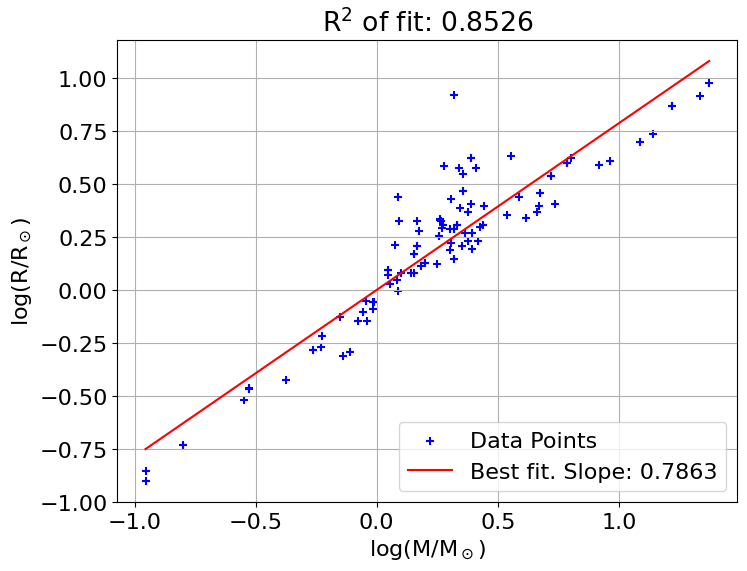

In [5]:
import matplotlib.pyplot as plt

matplotlib.rc('font', size=16)
plt.rcParams["figure.figsize"] = (8,6)

plt.scatter(x, y, color='blue', marker='+', label='Data Points')

# Generate values for the line with slope m and passing through the origin
x_line = np.linspace(min(x), max(x), 100)
y_line = lr.coef_[0] * x_line

# Plot the line with slope m
plt.plot(x_line, y_line, color='red', label=f'Best fit. Slope: {lr.coef_[0]:.4f}')

# Add labels and legend
plt.xlabel('log(M/M$_\odot$)')
plt.ylabel('log(R/R$_\odot$)')
plt.title(f"R$^2$ of fit: {r2_score(y, lr.predict(np.array(x).reshape(-1, 1))):.4f}")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [36]:
import numpy as np

m_sun = 1.99e30
mu = 1.66e-27
G = 6.6743e-11
ev_j = 6.24150907e18
m_ev = 1e-6
om_0 = -2.47e55
e = -om_0/2
om_1 = om_0 + e/2
erg_mev = 1.60217663e-6 
j_erg = 1e-7
j_mev = erg_mev*j_erg
E_int = 2.48e42 # J
kb = 1.380649e-23 # m2 kg s-2 K-1
N_he = 1.5e56
c = 299792458 # m / s
k = 0.034 # m2 / kg

# r=((3/5)*G*(0.5*m_sun)**2)/(-om_1*m_ev/ev_j)

# aux = (2*E_int)/(3*N_he*kb)

np.sqrt((4*np.pi*G*c)/k)

2.719435025200626

In [39]:
(3.2e4)**(1/3)

31.748021039363984

In [35]:
print(f"{r_f:.4e}")

1.8746e+07


In [32]:
omega_f  = -1.32e55*j_mev

In [34]:
r_f = (-G*3*(0.5*m_sun)**2)/(5*omega_f)

In [17]:
omega_0 = (-2.47e55)*erg_mev*j_erg 
omega_f = omega_0 + 1.15e55*erg_mev*j_erg
omega_f

-2.1148731516000002e+42

WD exercices

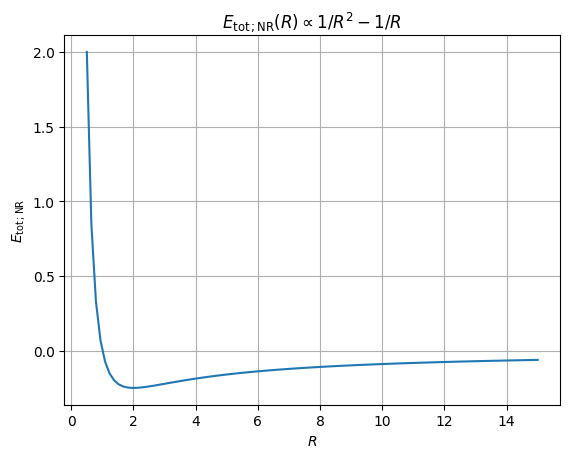

In [38]:
import numpy as np
import matplotlib.pyplot as plt

r = np.linspace(0.5, 15, 100)
f = 1/(r**2)-1/r

plt.plot(r, f)
plt.title("$E_{\\rm{tot\,;NR}}(R) \propto 1/R^2-1/R$")
plt.xlabel("$R$")
plt.ylabel("$E_{\\rm{tot\,;NR}}$")
plt.grid()

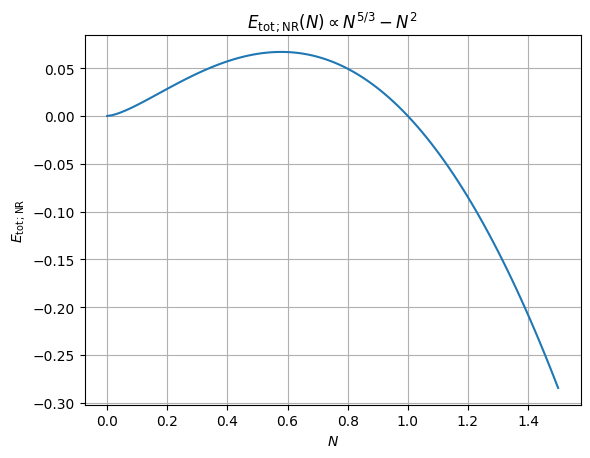

In [37]:
n = np.linspace(0, 1.5, 100)
f = n**(5/3) - n**2

plt.plot(n, f)
plt.title("$E_{\\rm{tot\,;NR}}(N) \propto N^{5/3}-N^2$")
plt.xlabel("$N$")
plt.ylabel("$E_{\\rm{tot\,;NR}}$")
plt.grid()

In [48]:
h = 1e-34
me = 1e-30
N = 1e45
G = 1e-11
mn = 1e-15
C = h/(me*G)

((h*h)/(me*C*C))*N**(7/3)

1.000000000000015e+53

In [49]:
((G*mn*mn)/(C))*N**(7/3)

1.0000000000000154e+57

## Elementary particles exercises

In [4]:
import numpy as np

m_p = 139.6 # MeV
p_f = 410 # MeV
E_f = np.sqrt(m_p ** 2 + p_f ** 2)

m_0 = np.sqrt(2*m_p**2 + 15*p_f**2 + 2*E_f**2)
m_0

1713.3746350404513

## Cosmology exercises

In [4]:
# Funciones para calcular las distancias

from scipy.integrate import simpson
import numpy as np

H_0 = 71   # km s-1 Mpc-1
c = 299792.458   # km s-1

def d_com(a, omega_m = 0.3, omega_lb = 0.7):
    omega_k = 1 - omega_m - omega_lb
    return 1/(a*omega_m + omega_k*a**2 + omega_lb*a**4)**(1/2)

def get_comoving_distance_array(a_array, omega_m = 0.3, omega_lb = 0.7):

    z = []
    d_comoving = []

    for a_0 in a_array:
        
        z.append((1/a_0)-1)

        a = np.linspace(a_0, 1, 1000)
        d_comoving.append(simpson(y = d_com(a, omega_m = omega_m, omega_lb = omega_lb), x = a))

    return np.array(z), np.array(d_comoving)*(c/H_0)

def s_k(x, k):

    if k > 0:
        return (1/np.sqrt(k))*np.sin(np.sqrt(k)*x)
    elif k < 0:
        return (1/np.sqrt(-k))*np.sinh(np.sqrt(-k)*x)
    elif k == 0:
        return x
    
def luminosity_distance(a_array, omega_m = 0.3, omega_lb = 0.7):

    k = (omega_m + omega_lb - 1)*(H_0/c)**2
    z, d_co = get_comoving_distance_array(a_array, omega_m, omega_lb)

    return z, (1+z)*s_k(d_co, k)

def angular_distance(a_array, omega_m = 0.3, omega_lb = 0.7):

    k = (omega_m + omega_lb - 1)*(H_0/c)**2
    z, d_co = get_comoving_distance_array(a_array, omega_m, omega_lb)

    return z, (1/(1 + z))*s_k(d_co, k)

Text(0.5, 0, 'Redshift ($z$)')

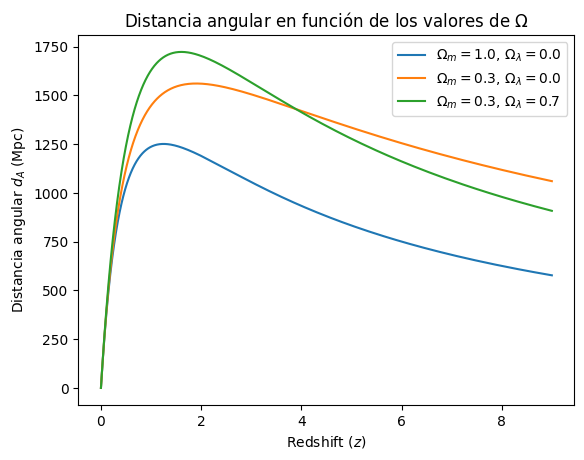

In [5]:
import matplotlib.pyplot as plt

a_array = np.linspace(0.1, 1.0, 500)

for om_m, om_lb in zip([1.0, 0.3, 0.3], [0.0, 0.0, 0.7]):
    z, d_l = angular_distance(a_array, om_m, om_lb)
    plt.plot(z, d_l, label = f"$\Omega_m = {om_m}$, $\Omega_\lambda = {om_lb}$")

plt.title("Distancia angular en función de los valores de $\Omega$")
plt.legend()
plt.ylabel("Distancia angular $d_A$ (Mpc)")
plt.xlabel("Redshift ($z$)")

Text(0.5, 0, 'Redshift ($z$)')

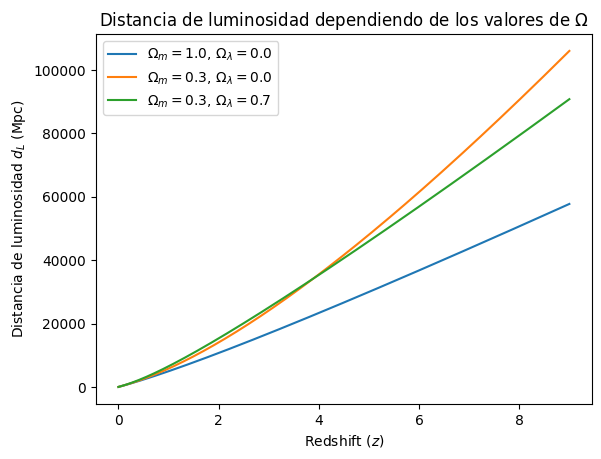

In [6]:
for om_m, om_lb in zip([1.0, 0.3, 0.3], [0.0, 0.0, 0.7]):
    z, d_l = luminosity_distance(a_array, om_m, om_lb)
    plt.plot(z, d_l, label = f"$\Omega_m = {om_m}$, $\Omega_\lambda = {om_lb}$")

plt.title("Distancia de luminosidad dependiendo de los valores de $\Omega$")
plt.legend()
plt.ylabel("Distancia de luminosidad $d_L$ (Mpc)")
plt.xlabel("Redshift ($z$)")

In [11]:
def distance_ratio(z):
    return (2/z)*(1-(1/(np.sqrt(1+z))))

def ap_magnitude_difference(z):
    return 5*np.log10(distance_ratio(z))

print(f"$z = 1 \\rightarrow $ {ap_magnitude_difference(1):.4f}")
print(f"$z = 3 \\rightarrow $ {ap_magnitude_difference(3):.4f}")

$z = 1 \rightarrow $ -1.1613
$z = 3 \rightarrow $ -2.3856


In [15]:
(3.3e-6)*13.8

4.554000000000001e-05

### Neutron stars exercise

In [119]:
import numpy as np

R = 1000000 # cm
M_ = 1.5 # Msun
B = 1e13 # G
P = 20e-3 # s
sigma = 6e22 # s-1
c = 29979245800 # cm / s
g_msun = 1.989e33 # g / Msun
M = M_*g_msun

I = (2/5)*M*R**2
tau = (4*np.pi*sigma*R**2)/(c**2)
k = np.sqrt((3*I*c**3)/(8*(np.pi**2)*R**6))

def b_t(t, b_0):
    return b_0 * np.exp(-t/tau)

def p_t(t, p_0, b_0):
    coef = (tau*b_0**2)/(k**2)
    return np.sqrt((p_0**2)+coef*(1-np.exp(-2*t/tau)))

def pdot_t(t, p_0, b_0):
    p = p_t(t, p_0, b_0)
    cf = (b_0**2)/(p*k**2)
    return cf*np.exp(-2*t/tau)

def sd_lum(t, p_0, b_0):
    pdot = pdot_t(t, p_0, b_0)
    p = p_t(t, p_0, b_0)
    return -(4*I*pdot*np.pi**2)/(p**3)

def t_c(t, p_0, b_0):
    pdot = pdot_t(t, p_0, b_0)
    p = p_t(t, p_0, b_0)
    return p/(2*pdot)

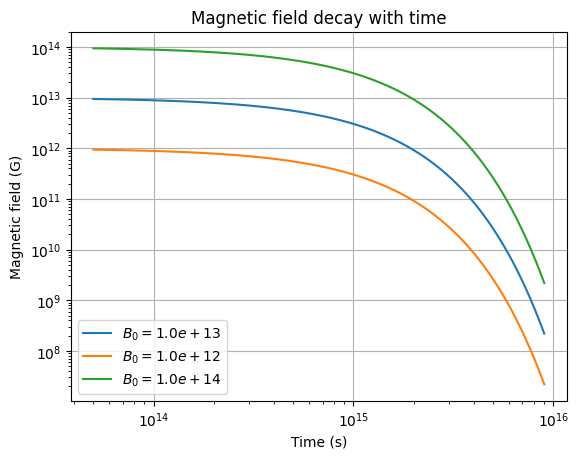

In [2]:
import matplotlib.pyplot as plt

t = np.linspace(5e13, 9e15, 100000)

b_0 = 1e13
b_1 = 1e12
b_2 = 1e14

p_0 = 20e-3
p_1 = 50e-2
p_2 = 5e-3

plt.plot(t, b_t(t, b_0), label = f"$B_0={b_0:.1e}$")
plt.plot(t, b_t(t, b_1), label = f"$B_0={b_1:.1e}$")
plt.plot(t, b_t(t, b_2), label = f"$B_0={b_2:.1e}$")
plt.xscale('log')
plt.yscale('log')
plt.grid()
_=plt.legend()
plt.ylabel("Magnetic field (G)")
plt.xlabel("Time (s)")
_=plt.title("Magnetic field decay with time")


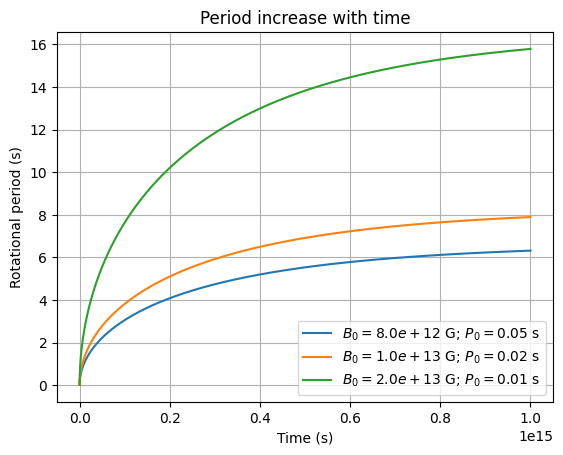

In [131]:
b_0 = 1e13
b_1 = 8e12
b_2 = 2e13

p_0 = 2e-2
p_1 = 5e-2
p_2 = 1e-2

t = np.linspace(1, 1e15, 10000)

fig, ax = plt.subplots()

ax.plot(t, p_t(t, p_1, b_1), label = f"$B_0={b_1:.1e}$ G; $P_0={p_1}$ s")
ax.plot(t, p_t(t, p_0, b_0), label = f"$B_0={b_0:.1e}$ G; $P_0={p_0}$ s")
ax.plot(t, p_t(t, p_2, b_2), label = f"$B_0={b_2:.1e}$ G; $P_0={p_2}$ s")

plt.grid()
_=plt.legend()
plt.ylabel("Rotational period (s)")
plt.xlabel("Time (s)")
_=plt.title("Period increase with time")

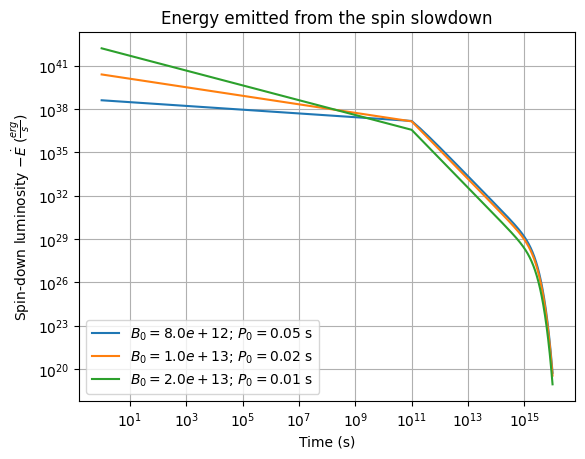

In [129]:
import matplotlib.pyplot as plt

t = np.linspace(1, 1e16, 100000)

plt.plot(t, -sd_lum(t, p_1, b_1), label = f"$B_0={b_1:.1e}$; $P_0={p_1}$ s")
plt.plot(t, -sd_lum(t, p_0, b_0), label = f"$B_0={b_0:.1e}$; $P_0={p_0}$ s")
plt.plot(t, -sd_lum(t, p_2, b_2), label = f"$B_0={b_2:.1e}$; $P_0={p_2}$ s")
plt.xscale('log')
plt.yscale('log')
plt.grid()
_=plt.legend()
plt.ylabel("Spin-down luminosity $-\\dot{E}$ $(\\frac{erg}{s})$")
plt.xlabel("Time (s)")
_=plt.title("Energy emitted from the spin slowdown")


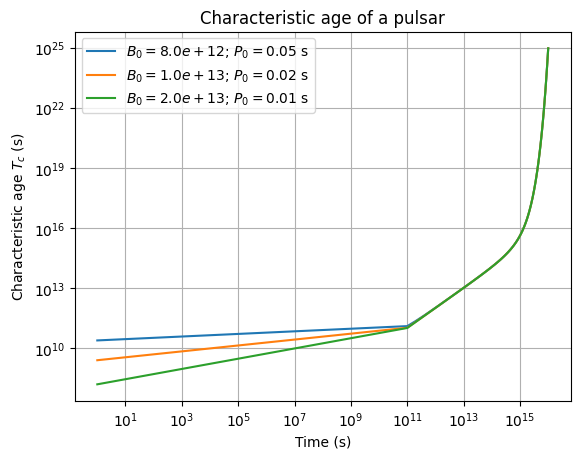

In [128]:
import matplotlib.pyplot as plt

t = np.linspace(1, 1e16, 100000)
# t = np.linspace(0, 100, 100000)


plt.plot(t, t_c(t, p_1, b_1), label = f"$B_0={b_1:.1e}$; $P_0={p_1}$ s")
plt.plot(t, t_c(t, p_0, b_0), label = f"$B_0={b_0:.1e}$; $P_0={p_0}$ s")
plt.plot(t, t_c(t, p_2, b_2), label = f"$B_0={b_2:.1e}$; $P_0={p_2}$ s")
plt.xscale('log')
plt.yscale('log')
plt.grid()
_=plt.legend()
plt.ylabel("Characteristic age $T_c$ (s)")
plt.xlabel("Time (s)")
_=plt.title("Characteristic age of a pulsar")


### Supernova Ia

$B_{max}$ is the apparent magnitude
$\Delta m_{15}$ is the correction factor

So we have to get the absolute magnitude as $M=-21.726+2.698\Delta m_{15}$ and then compute the distance as $d_L = 10^{\frac{m-M}{5}+1}$

In [32]:
import pandas as pd
from sklearn.linear_model import LinearRegression as lr
import numpy as np
import matplotlib.pyplot as plt

file_path = "/home/nino/GW/Keras-Project-Template/data/Ia-table.txt"
# Skip the header information and load only the table
df = pd.read_csv(file_path, sep="\t", skiprows=6)

# Display the DataFrame
df.columns

m = df['B_max'].values
M = -21.726+2.698*df['\\delta m_{15}'].values
dl = 10**((m-M)/5 + 1) /1e6 # Mpc
v = 10**df['log v'].values

reg = lr(fit_intercept=True)

reg.fit(X = dl.reshape(-1, 1), y = v)

LinearRegression()

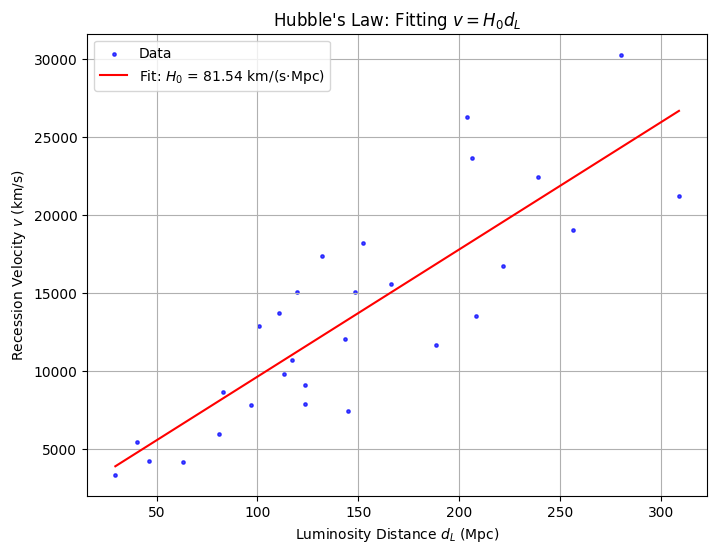

Calculated Hubble Constant: H_0 = 81.54 km/(s$\cdot$Mpc)


In [38]:
# Generate predictions for the regression line
dl_range = np.linspace(dl.min(), dl.max(), 500).reshape(-1, 1)
v_pred = reg.predict(dl_range)

# Plot the data and the regression line
plt.figure(figsize=(8, 6))
plt.scatter(dl, v, color='blue', label="Data", alpha=0.7, s = 5.8)
plt.plot(dl_range, v_pred, color='red', label=f"Fit: $H_0$ = {reg.coef_[0]:.2f} km/(s$\cdot$Mpc)")
plt.xlabel("Luminosity Distance $d_L$ (Mpc)")
plt.ylabel("Recession Velocity $v$ (km/s)")
plt.title("Hubble's Law: Fitting $v = H_0 d_L$")
plt.legend()
plt.grid()
plt.show()

# Print the fitted Hubble constant
print(f"Calculated Hubble Constant: H_0 = {reg.coef_[0]:.2f} km/(s$\cdot$Mpc)")